In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from scipy.optimize import curve_fit
from numpy import exp
from scipy import ndimage
from func import *
from numpy import asarray
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.ndimage.filters import gaussian_filter
from matplotlib.colors import LogNorm
from astropy.table import Table, hstack
import os
import glob
from astropy.table import Table, vstack, join
import pandas as pd
from shutil import copyfile
import decimal

In [11]:
def red_data_err(data,model,res,x0,y0,x_m,y_m,muse_sampling_size,box_size=3):
    if muse_sampling_size == 0.4:
        (y_cen,x_cen)=(int(round(y_m)),int(round(x_m)))
        data_red = data[y_cen-box_size:y_cen+box_size+1,x_cen-box_size:x_cen+box_size+1]
        mod_red = model[y_cen-box_size:y_cen+box_size+1,x_cen-box_size:x_cen+box_size+1]
        residual_red = res[y_cen-box_size:y_cen+box_size+1,x_cen-box_size:x_cen+box_size+1]
        (x0,y0)=(x0-7,y0-7)
    else:
        (y_cen,x_cen)=(int(round(y_m)),int(round(x_m)))
        data_red = data[y_cen-2*box_size-1:y_cen+2*box_size+2,x_cen-2*box_size-1:x_cen+2*box_size+2]
        mod_red =model[y_cen-2*box_size-1:y_cen+2*box_size+2,x_cen-2*box_size-1:x_cen+2*box_size+2]
        residual_red =res[y_cen-2*box_size-1:y_cen+2*box_size+2,x_cen-2*box_size-1:x_cen+2*box_size+2]
        (x0,y0)=(x0-14,y0-14)
    #plt.imshow(data_red,origin='lower')
    #plt.show()
    err_red = (data_red - mod_red)/residual_red
    return data_red,mod_red,residual_red,err_red,x0,y0 

In [12]:
def res_filter(res):
    res[res<10**(-4)]=0
    return res

In [13]:
def offset_orig(obj,muse_sampling_size,d_a,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    hdu = fits.open('%s/%s/9_arcsec_moffat_table_%s.fits'%(destination_path_cube,obj,obj))
    central_tab = hdu[1].data
    central_columns = hdu[1].header
    (Hb_x,Hb_y) = (central_tab.field('x0_Hb_Blr')[0],central_tab.field('y0_Hb_Blr')[0])
    (OIII_br_x,OIII_br_y) = (central_tab.field('x0_OIII_br')[0],central_tab.field('y0_OIII_br')[0])
    (OIII_nr_x,OIII_nr_y) = (central_tab.field('x0_OIII_nr')[0],central_tab.field('y0_OIII_nr')[0])
    offset_OIII_br_pixel= np.sqrt((OIII_br_x - Hb_x)**2+(OIII_br_y - Hb_y)**2)
    offset_OIII_nr_pixel= np.sqrt((OIII_nr_x - Hb_x)**2+(OIII_nr_y - Hb_y)**2)
    offset_OIII_br_arc = muse_sampling_size*offset_OIII_br_pixel
    offset_OIII_nr_arc = muse_sampling_size*offset_OIII_nr_pixel
    offset_OIII_br_pc = 4.848*d_a*offset_OIII_br_arc
    offset_OIII_nr_pc = 4.848*d_a*offset_OIII_nr_arc
    return offset_OIII_br_pixel,offset_OIII_nr_pixel,offset_OIII_br_arc,offset_OIII_nr_arc,offset_OIII_br_pc,offset_OIII_nr_pc

def offset_coord(obj,muse_sampling_size,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    hdu = fits.open('%s/%s/9_arcsec_moffat_table_%s.fits'%(destination_path_cube,obj,obj))
    central_tab = hdu[1].data
    central_columns = hdu[1].header
    (Hb_x,Hb_y) = (central_tab.field('x0_Hb_Blr')[0],central_tab.field('y0_Hb_Blr')[0])
    (OIII_br_x,OIII_br_y) = (central_tab.field('x0_OIII_br')[0],central_tab.field('y0_OIII_br')[0])
    (OIII_nr_x,OIII_nr_y) = (central_tab.field('x0_OIII_nr')[0],central_tab.field('y0_OIII_nr')[0])
    offset_OIII_br_pixel= [(OIII_br_x - Hb_x),(OIII_br_y - Hb_y)]
    offset_OIII_nr_pixel= [(OIII_nr_x - Hb_x),(OIII_nr_y - Hb_y)]
    offset_OIII_br_arc = [muse_sampling_size*offset_OIII_br_pixel[0],muse_sampling_size*offset_OIII_br_pixel[1]]
    offset_OIII_nr_arc = [muse_sampling_size*offset_OIII_nr_pixel[0],muse_sampling_size*offset_OIII_nr_pixel[1]]
    return offset_OIII_br_arc,offset_OIII_nr_arc

In [14]:
def offset_table(offset_data,obj,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    column_names={'off_pix_wing':0,'off_pix_core':1,'off_arc_wing':2,'off_arc_core':3,'off_pc_wing':4,'off_pc_core':5}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[offset_data[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s/%s/%s_offsettable.fits'%(destination_path_cube,obj,obj),overwrite=True)
    
def fluxden_compare(obj,Hb_data,OIII_br_data,Hb_model,OIII_br_model,sigma_eff_OIII_br,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    f_blr_data = np.sum(Hb_data)
    
    f_wing_data = np.sum(OIII_br_data)
    f_blr_model = np.sum(Hb_model)
    f_wing_model = np.sum(OIII_br_model)
    print (f_wing_data/f_wing_model)
    tab_par = [f_blr_data,f_wing_data,f_blr_model,f_wing_model]
    column_names={'flux_blr_data':0,'flux_wing_data':1,'flux_blr_model':2,'flux_wing_model':3}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[tab_par[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s/%s/%s_fluxdensity.fits'%(destination_path_cube,obj,obj),overwrite=True)

def offset_comp_table(obj,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    t1 = Table.read('%s/%s/source_%s.fits'%(destination_path_cube,obj,obj),format='fits')
    t2 = Table.read('%s/%s/%s_offsettable.fits'%(destination_path_cube,obj,obj),format='fits')
    new = hstack([t1, t2])
    new.write('%s/%s/%s_offsettable.fits'%(destination_path_cube,obj,obj),overwrite=True)
    
def fluxden_comp_table(obj,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    t1 = Table.read('%s/%s/source_%s.fits'%(destination_path_cube,obj,obj),format='fits')
    t2 = Table.read('%s/%s/%s_fluxdensity.fits'%(destination_path_cube,obj,obj),format='fits')
    new = hstack([t1, t2])
    new.write('%s/%s/%s_fluxdensity4.fits'%(destination_path_cube,obj,obj),overwrite=True)
    
def hundred_pc_circle(d_a):
    arc_100pc = 100/(4.848*d_a)
    return arc_100pc 

def scientific_notation(p):
    if p < 0.01:
        k = 10**(np.log10(p) - np.round(np.log10(p)))
        q = np.round(k,2)
        l = int(np.log10(p/q))
    else:
        q = np.round(p,2)
        l = 0
    return (l,q)   

In [33]:
def full_comparison_plots(obj,x_min,x_max,y_min,y_max,arc_OIII_br,arc_OIII_nr,Hb_data,Hb_model,Hb_res,OIII_br_data,OIII_br_model,OIII_br_res,OIII_nr_data,OIII_nr_model,OIII_nr_res,Hb_small_res,OIII_br_small_res,OIII_nr_small_res,p_val_wing,p_val_core,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    plt.rcParams.update({'font.size': 18})
    cmap = 'copper'
    plt.rcParams['axes.linewidth'] = 1.2
    plt.rcParams['axes.edgecolor'] = 'k'

    bins = np.linspace(-10, 10, 50)
    no_max,offset_max,_ = plt.hist(Hb_small_res.ravel(),bins)
    y_position = int(0.8*np.max(no_max))
    print (y_position)
    #plt.rcParams["axes.grid"] = False
    fig = plt.figure(figsize=(20, 12)) 
    
    ax1 = fig.add_axes([0.02,0.64,0.27,0.27])
    ax2 = fig.add_axes([0.19,0.64,0.27,0.27])
    ax3 = fig.add_axes([0.36,0.64,0.27,0.27])
    ax4 = fig.add_axes([0.02,0.36,0.27,0.27])
    ax5 = fig.add_axes([0.19,0.36,0.27,0.27])
    ax6 = fig.add_axes([0.36,0.36,0.27,0.27])
    ax7 = fig.add_axes([0.02,0.08,0.27,0.27])
    ax8 = fig.add_axes([0.19,0.08,0.27,0.27])
    ax9 = fig.add_axes([0.36,0.08,0.27,0.27])
    ax10 = fig.add_axes([0.67,0.08,0.27,0.33])
    ax11 = fig.add_axes([0.67,0.43,0.27,0.33])
    cbaxes1 = fig.add_axes([0.58, 0.36, 0.015, 0.42]) 
    cbaxes2 = fig.add_axes([0.58, 0.08, 0.015, 0.27]) 

    Hb_data = Hb_data/np.max(Hb_data)
    Hb_data[Hb_data<0]=0.000001
    ax1.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=18)
    ax1.imshow(Hb_data,origin ='lower',interpolation ='nearest',cmap=cmap,extent = [x_min,x_max,y_min,y_max],vmax=1,vmin=0.001)
    ax1.plot(0,0,'rx',mew=2)
    ax1.plot(arc_OIII_br[0],arc_OIII_br[1],'gx',mew=2)
    ax1.plot(arc_OIII_nr[0],arc_OIII_nr[1],'bx',mew=2)
    ax1.set_xticks([])
    ax1.set_ylabel(r"$\Delta$y[arcsec]",fontsize=18)
    ax1.set_title(r"Broad H$\beta$ map",fontsize=18)
    ax1.text(-1.5,1.45,r'Light Profile',color='w',fontsize=18)
    ax1.grid(False)

    OIII_br_data = OIII_br_data/np.max(OIII_br_data)
    OIII_br_data[OIII_br_data<0]=0.000001
    ax2.imshow(OIII_br_data,origin ='lower',interpolation ='nearest',cmap=cmap,extent = [x_min,x_max,y_min,y_max],vmax=1,vmin=0.001)
    ax2.plot(0,0,'rx',mew=2)
    ax2.plot(arc_OIII_br[0],arc_OIII_br[1],'gx',mew=2)
    ax2.plot(arc_OIII_nr[0],arc_OIII_nr[1],'bx',mew=2)
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_title("[OIII] wing map",fontsize=18)
      
    OIII_nr_data = OIII_nr_data/np.max(OIII_nr_data)
    OIII_nr_data[OIII_nr_data<0]=0.000001
    ax3.imshow(OIII_nr_data,origin ='lower',interpolation ='nearest',cmap=cmap,extent = [x_min,x_max,y_min,y_max],vmax=1,vmin=0.001)
    ax3.plot(0,0,'rx',label= r'Broad H$\beta$ center',mew=2)
    ax3.plot(arc_OIII_br[0],arc_OIII_br[1],'gx',label='[OIII] wing center',mew=2)
    ax3.plot(arc_OIII_nr[0],arc_OIII_nr[1],'bx',label='[OIII] core center',mew=2)
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax3.legend(facecolor='lightgray', framealpha=3,bbox_to_anchor=(2.01, 1.03))
    ax3.set_title("[OIII] core map",fontsize=18)
    
    Hb_model = Hb_model/np.max(Hb_model)
    ax4.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=18)
    ax4.imshow(Hb_model,origin ='lower',interpolation ='nearest',cmap=cmap,extent = [x_min,x_max,y_min,y_max],vmax=1,vmin=0.001)
    ax4.plot(0,0,'rx',mew=2)
    ax4.plot(arc_OIII_br[0],arc_OIII_br[1],'gx',mew=2)
    ax4.plot(arc_OIII_nr[0],arc_OIII_nr[1],'bx',mew=2)
    ax4.set_xticks([])
    ax4.set_ylabel(r"$\Delta$y[arcsec]",fontsize=18)
    ax4.text(-1.5,1.45,r'Moffat model',color='w',fontsize=18)
    ax4.grid(False)

    OIII_br_model = OIII_br_model/np.max(OIII_br_model)
    ax5.imshow(OIII_br_model,origin ='lower',interpolation ='nearest',cmap=cmap,extent = [x_min,x_max,y_min,y_max],vmax=1,vmin=0.001)
    ax5.plot(0,0,'rx',mew=2)
    ax5.plot(arc_OIII_br[0],arc_OIII_br[1],'gx',mew=2)
    ax5.plot(arc_OIII_nr[0],arc_OIII_nr[1],'bx',mew=2)
    ax5.set_xticks([])
    ax5.set_yticks([])
  
    OIII_nr_model = OIII_nr_model/np.max(OIII_nr_model)
    ax6.imshow(OIII_nr_model,origin ='lower',interpolation ='nearest',cmap=cmap,extent = [x_min,x_max,y_min,y_max],vmax=1,vmin=0.001)
    fig6 = ax6.imshow(OIII_nr_model,origin ='lower',interpolation ='nearest',cmap=cmap,extent = [x_min,x_max,y_min,y_max],vmax=1,vmin=0.001)
    ax6.plot(0,0,'rx',mew=2)
    ax6.plot(arc_OIII_br[0],arc_OIII_br[1],'gx',mew=2)
    ax6.plot(arc_OIII_nr[0],arc_OIII_nr[1],'bx',mew=2)
    ax6.set_xticks([])
    ax6.set_yticks([])
    cb = plt.colorbar(fig6, cax = cbaxes1) 

    ax7.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=18)
    ax7.imshow(Hb_res,origin ='lower',interpolation ='nearest',extent = [x_min,x_max,y_min,y_max],cmap='RdBu',vmax=5,vmin=-5)
    ax7.set_xlabel(r"$\Delta$x[arcsec]",fontsize=18)
    ax7.set_ylabel(r"$\Delta$y[arcsec]",fontsize=18)
    ax7.text(-1.5,1.45,r'Normalized residual',color='black',fontsize=18)
    ax7.grid(False)
 
    ax8.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=18)
    ax8.imshow(OIII_br_res,origin ='lower',interpolation ='nearest',extent = [x_min,x_max,y_min,y_max],cmap='RdBu',vmax=5,vmin=-5)
    ax8.set_yticks([])
    ax8.set_xlabel(r"$\Delta$x[arcsec]",fontsize=18)
    ax8.grid(False)

    ax9.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=18)
    ax9.imshow(OIII_nr_res,origin ='lower',interpolation ='nearest',extent = [x_min,x_max,y_min,y_max],cmap='RdBu',vmax=5,vmin=-5)
    fig9 = ax9.imshow(OIII_nr_res,origin ='lower',interpolation ='nearest',extent = [x_min,x_max,y_min,y_max],cmap='RdBu',vmax=5,vmin=-5)
    ax9.set_yticks([])
    ax9.set_xlabel(r"$\Delta$x[arcsec]",fontsize=18)
    ax9.grid(False)
    cb = plt.colorbar(fig9, cax = cbaxes2) 
    
    plt.rcParams["axes.grid"] = True  
    plt.style.use('ggplot')
    bins = np.linspace(-10, 10, 50)
    ax10.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=18) 
    ax10.hist(Hb_small_res.ravel(),bins,alpha=0.5,label=r'BLR H$\beta$')
    ax10.hist(OIII_nr_small_res.ravel(),bins,alpha=0.5,label=r'[OIII] core')
    ax10.set_xlabel('Normalized residuals',fontsize=18)
    ax10.set_ylabel('Number',fontsize=18)
    ax10.legend(facecolor='white',framealpha=1,fontsize=18)
    ax10.minorticks_on()
    (exp_core,coeff_core) = scientific_notation(p_val_core[0])
    if exp_core ==0:
        ax10.text(-10,y_position,'p = %s'%(coeff_core),color='black',fontsize=18)
    else:
        ax10.text(-10,y_position,r'p = %s $\times 10^{%s}$'%(coeff_core,exp_core),color='black',fontsize=18)
    ax10.tick_params(axis='both',which='major',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=8)
    ax10.tick_params(axis='both',which='minor',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=4)
    
    plt.style.use('ggplot')
    bins = np.linspace(-10, 10, 50)
    ax11.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=18)
    ax11.hist(Hb_small_res.ravel(),bins,alpha=0.5,label=r'BLR H$\beta$')
    ax11.hist(OIII_br_small_res.ravel(),bins,color = 'k',alpha=0.5,label=r'[OIII] wing')
    ax11.set_ylabel('Number',fontsize=18)
    ax11.legend(facecolor='white',framealpha=1,fontsize=18)
    ax11.minorticks_on()
    (exp_wing,coeff_wing) = scientific_notation(p_val_wing[0])
    print (exp_wing,coeff_wing)
    if exp_wing ==0:
        ax11.text(-10,y_position,'p = %s'%(coeff_wing),color='black',fontsize=18)
    else:
        ax11.text(-10,y_position,r'p = %s $\times 10^{%s}$'%(coeff_wing,exp_wing),color='black',fontsize=18)
    plt.setp(ax11.get_xticklabels(), visible=False)
    ax11.tick_params(axis='both',which='major',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=8)
    ax11.tick_params(axis='both',which='minor',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=4)
    ax11.set_title(r'Histograms of normalized residuals (r<1")',fontsize=20)
    #ax11.text(-5,16,r'Histograms of nornalized',color='k',fontsize=20)
    #ax11.text(-2.5,15,r'residuals (r<1")',color='k',fontsize=20)

    fig.savefig('%s/Full Maps/%s_1_arcsec_maps.png'%(destination_path_cube,obj),overwrite=True)
    plt.show()


In [34]:
def algorithm_script(obj,asymmetry,d_a,prefix_path_cube="/media/mainak/Seagate/ftp.hidrive.strato.com/users/login-carsftp/IFU_data",destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    print ('%s'%(obj))
    (cont_cube,cont_err,cont_wave,cont_header) = loadCube('%s/MUSE/%s/fitting/full/%s.cont_model.fits'%(prefix_path_cube,obj,obj))
    muse_sampling_size = sampling_size(cont_cube)
    fixed_param = fixed_parameters(obj)
    vel_sigma_OIII_br = fixed_param[3]
    sigma_eff_OIII_br = line_width_recons(vel_sigma_OIII_br,rest_line=5006.8,inst_res_fwhm=0)

    (Hb_x,Hb_y,OIII_br_x,OIII_br_y,OIII_nr_x,OIII_nr_y) = moffat_centers(obj)  
          
    (Hb_data,Hb_model,blr_res,OIII_br_data,OIII_br_model,wing_res,OIII_nr_data,OIII_nr_model,core_res) = loadplot('%s/%s/9_arcsec_maps_%s.fits'%(destination_path_cube,obj,obj))
    
    half_box_shape = int((Hb_data.shape[0] - 1)/2)
    (y_m,x_m) = (half_box_shape,half_box_shape)
    (Hb_data,Hb_model,Hb_res,Hb_err,Hb_x,Hb_y) = red_data_err(Hb_data,Hb_model,blr_res,Hb_x,Hb_y,x_m,y_m,muse_sampling_size,box_size=3)
    (OIII_br_data,OIII_br_model,OIII_br_res,OIII_br_err,OIII_br_x,OIII_br_y) = red_data_err(OIII_br_data,OIII_br_model,wing_res,OIII_br_x,OIII_br_y,x_m,y_m,muse_sampling_size,box_size=3)
    (OIII_nr_data,OIII_nr_model,OIII_nr_res,OIII_nr_err,OIII_nr_x,OIII_nr_y) = red_data_err(OIII_nr_data,OIII_nr_model,core_res,OIII_nr_x,OIII_nr_y,x_m,y_m,muse_sampling_size,box_size=3)
    (y_m,x_m) = ndimage.measurements.maximum_position(Hb_data)
    print (x_m,y_m)
      
    flux_wing_data = np.sum(OIII_br_data)
    flux_wing_model = np.sum(OIII_br_model)
    flux_ratio = (flux_wing_data/flux_wing_model)
    
    box_size = np.shape(Hb_data)[1]
   
    fluxden_compare(obj,Hb_data,OIII_br_data,Hb_model,OIII_br_model,sigma_eff_OIII_br)
    fluxden_comp_table(obj)
    (arc_OIII_br,arc_OIII_nr) = offset_coord(obj,muse_sampling_size)
    print (arc_OIII_br,arc_OIII_nr)
    (x_min,x_max,y_min,y_max) = ranges_talk(Hb_x,Hb_y,muse_sampling_size,asymmetry)

    x, y = np.mgrid[:box_size, :box_size]
    if box_size==15: # in the 9" maps the length of the box with sources of spatial sampling is 45 whereas for the ones 
        radius = 5
    else:
        radius = 2.5
    [x0,y0] = ndimage.measurements.maximum_position(Hb_data) # Define the PSF center
    Hb_small_res = Hb_res[(x-x0)**2 + (y-y0)**2 <= radius**2]
    OIII_br_small_res = OIII_br_res[(x-x0)**2 + (y-y0)**2 <= radius**2]
    OIII_nr_small_res = OIII_nr_res[(x-x0)**2 + (y-y0)**2 <= radius**2]
    
    p_val_wing = [stats.levene(Hb_small_res.ravel(),OIII_br_small_res.ravel())[1]]
    p_val_core = [stats.levene(Hb_small_res.ravel(),OIII_nr_small_res.ravel())[1]]
    
    full_comparison_plots(obj,x_min,x_max,y_min,y_max,arc_OIII_br,arc_OIII_nr,Hb_data,Hb_model,Hb_res,OIII_br_data,OIII_br_model,OIII_br_res,OIII_nr_data,OIII_nr_model,OIII_nr_res,Hb_small_res,OIII_br_small_res,OIII_nr_small_res,p_val_wing,p_val_core)

HE0108-4743
8 6
0.988049345090214
[-0.1481029510498047, 0.028059005737304688] [-0.409182357788086, 0.02711334228515625]
16
-11 1.21


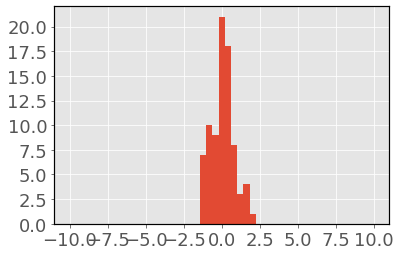

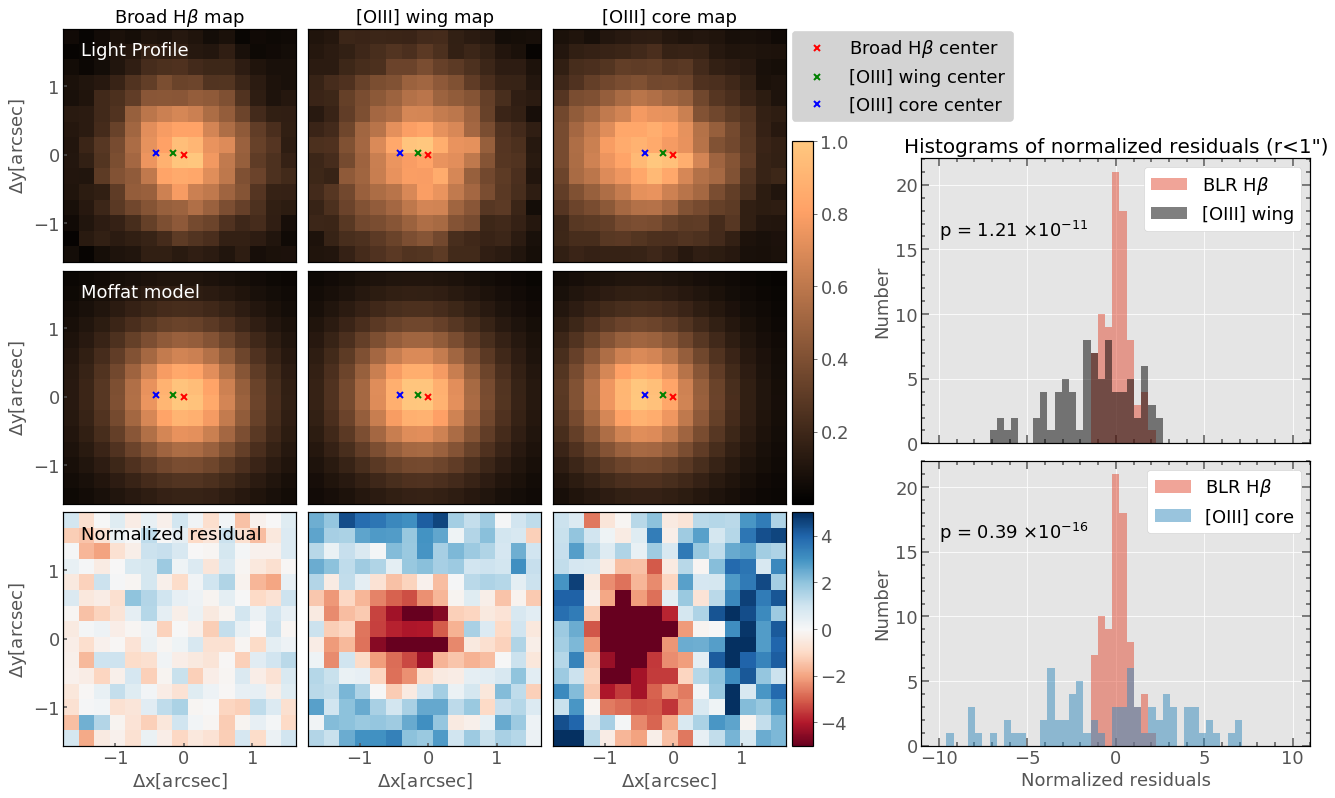

In [35]:
z = {"HE0108-4743":0.02392}

d_a = {"HE0108-4743":215.0}

asymmetry = {"HE0108-4743":True}

objs = z.keys()

for obj in objs:
    algorithm_script(obj,d_a[obj],asymmetry[obj])


HE0021-1810
1.0768566714205403
[-0.11886329650878907, -0.0660369873046875] [-0.014342498779296876, -0.0007881164550781251]
14
-11 0.61


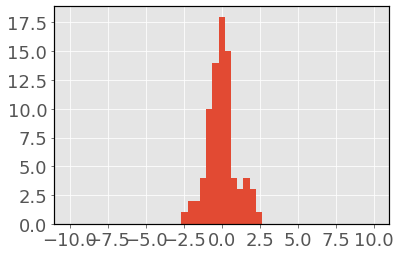

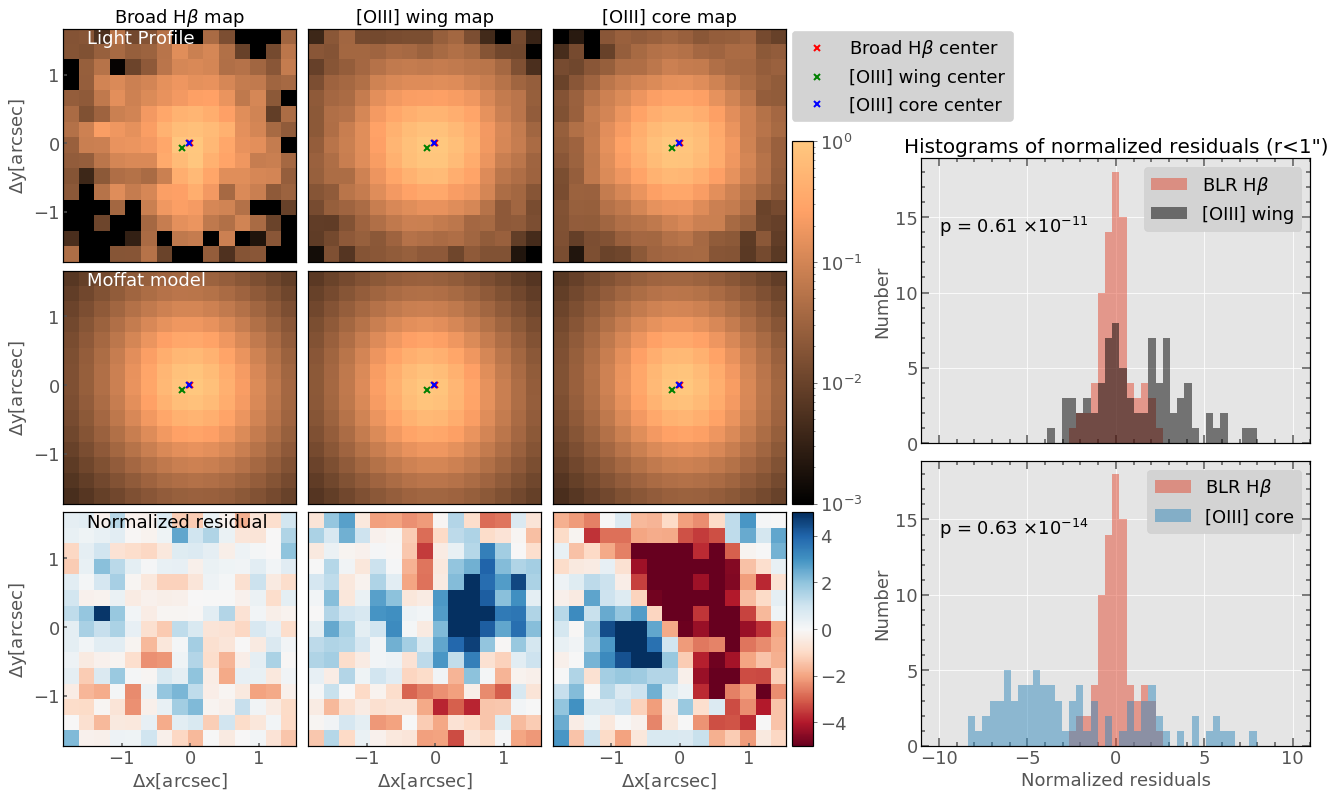

HE0021-1819
1.0085144537749262
[-0.052020263671875004, 0.032080459594726565] [-0.032051467895507814, -0.02312469482421875]
12
-2 0.53


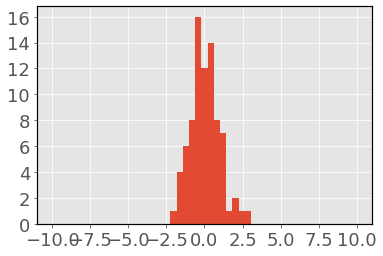

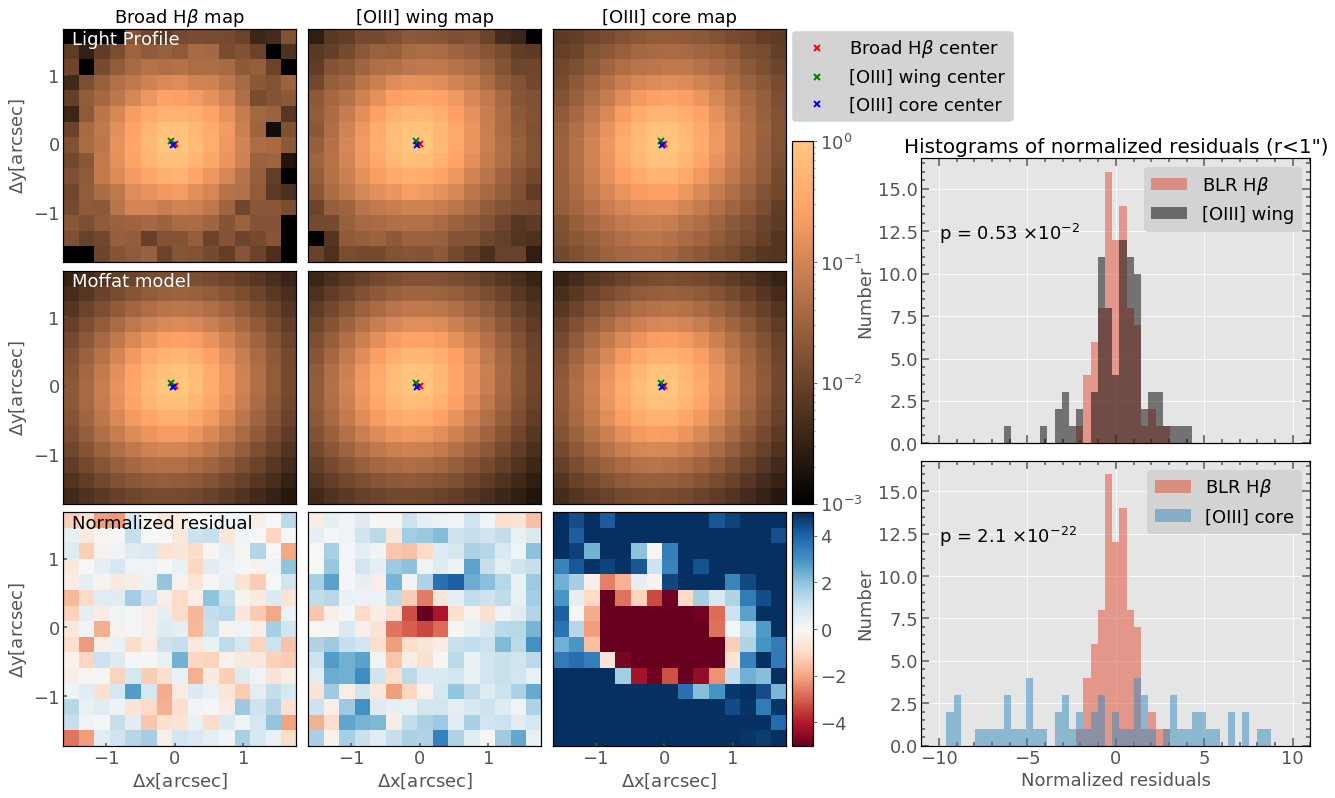

HE0040-1105
1.0126000112673625
[0.1064117431640625, -0.026505661010742188] [-0.03919143676757813, 0.039515686035156254]
8
0 0.88


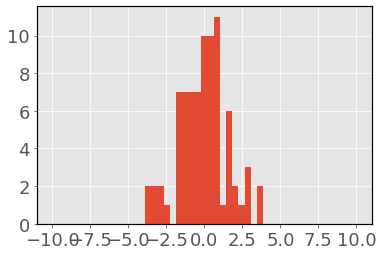

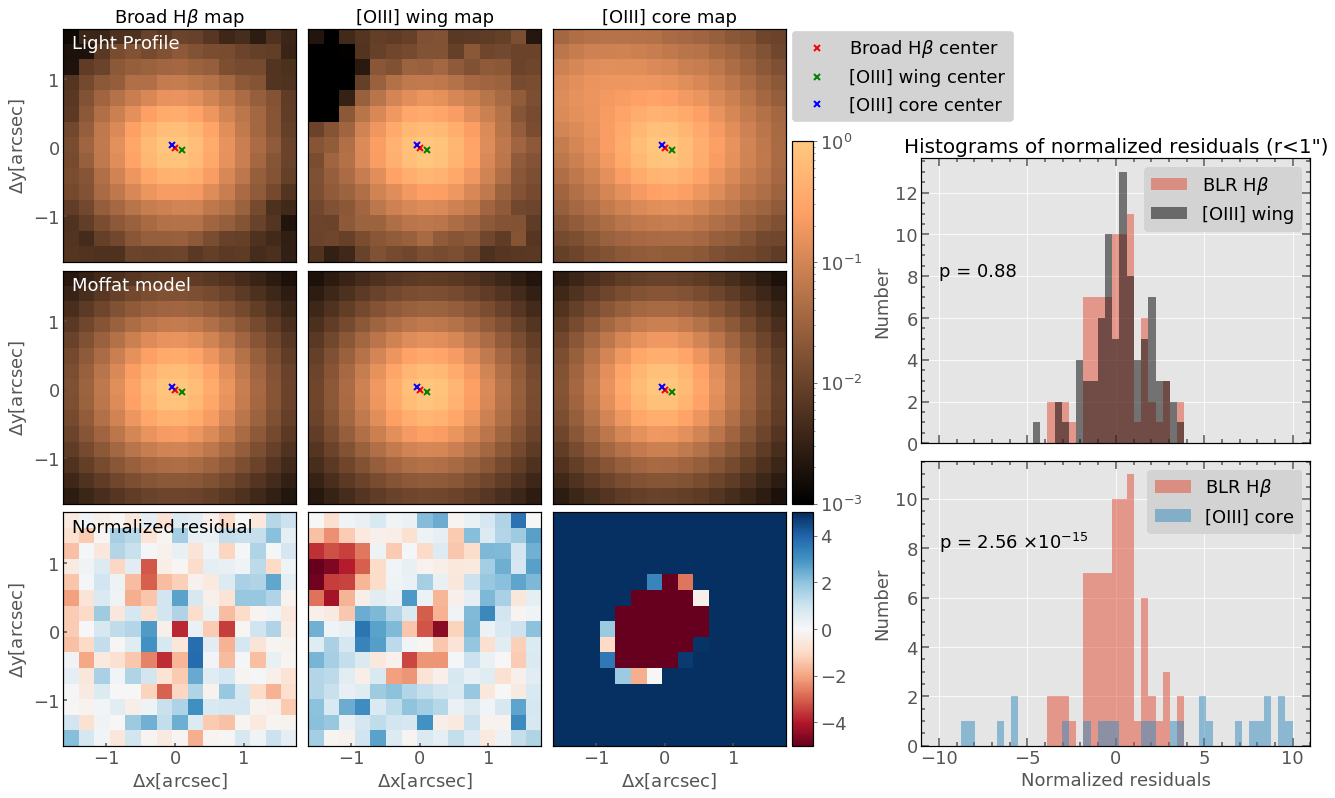

HE0108-4743
0.9214146701111401
[-0.1420135498046875, 0.0822845458984375] [-0.3590019226074219, 0.0508392333984375]
5
-2 0.78


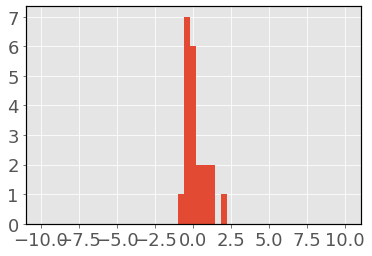

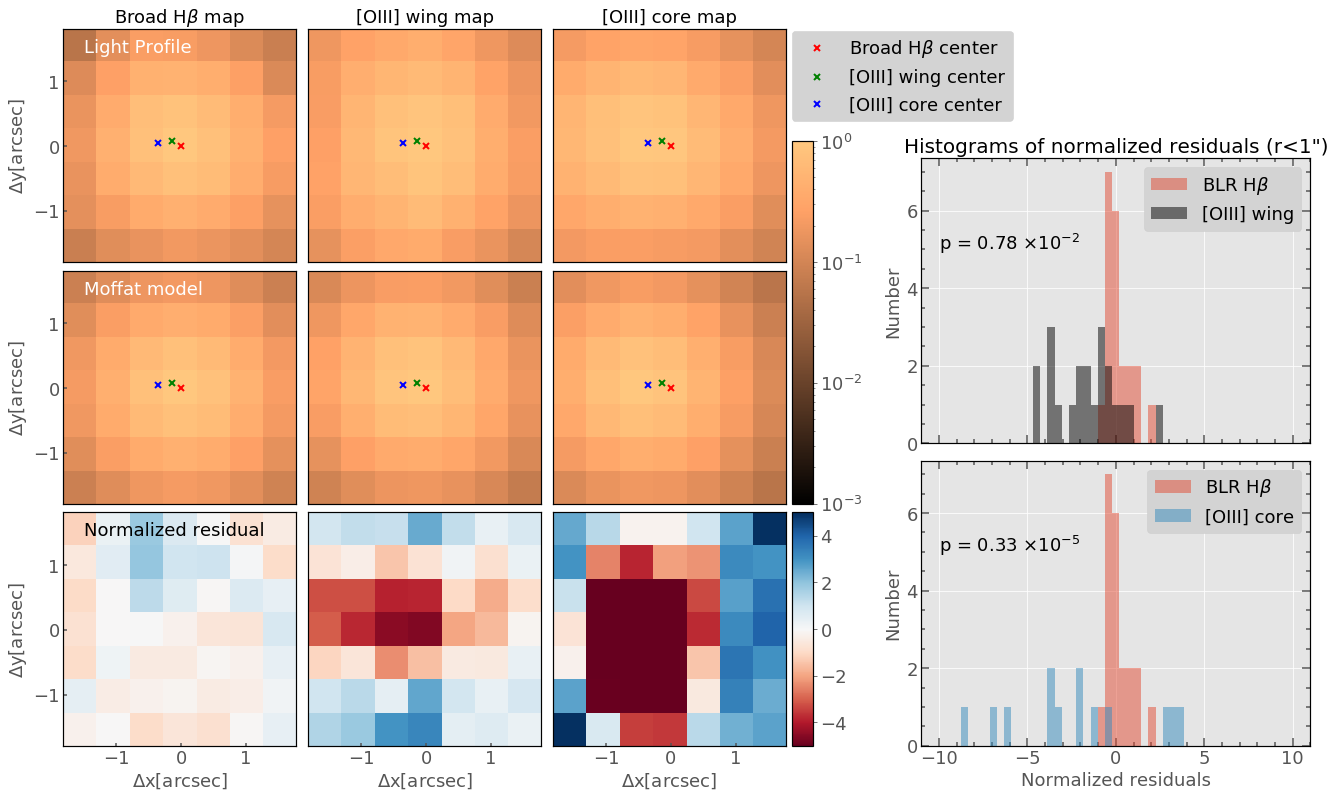

HE0114-0015
1.1010247055158249
[0.059649658203125004, 0.23644905090332033] [0.005495834350585938, 0.015538787841796875]
11
0 0.7


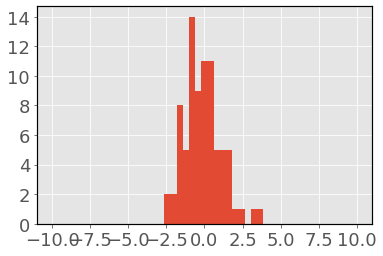

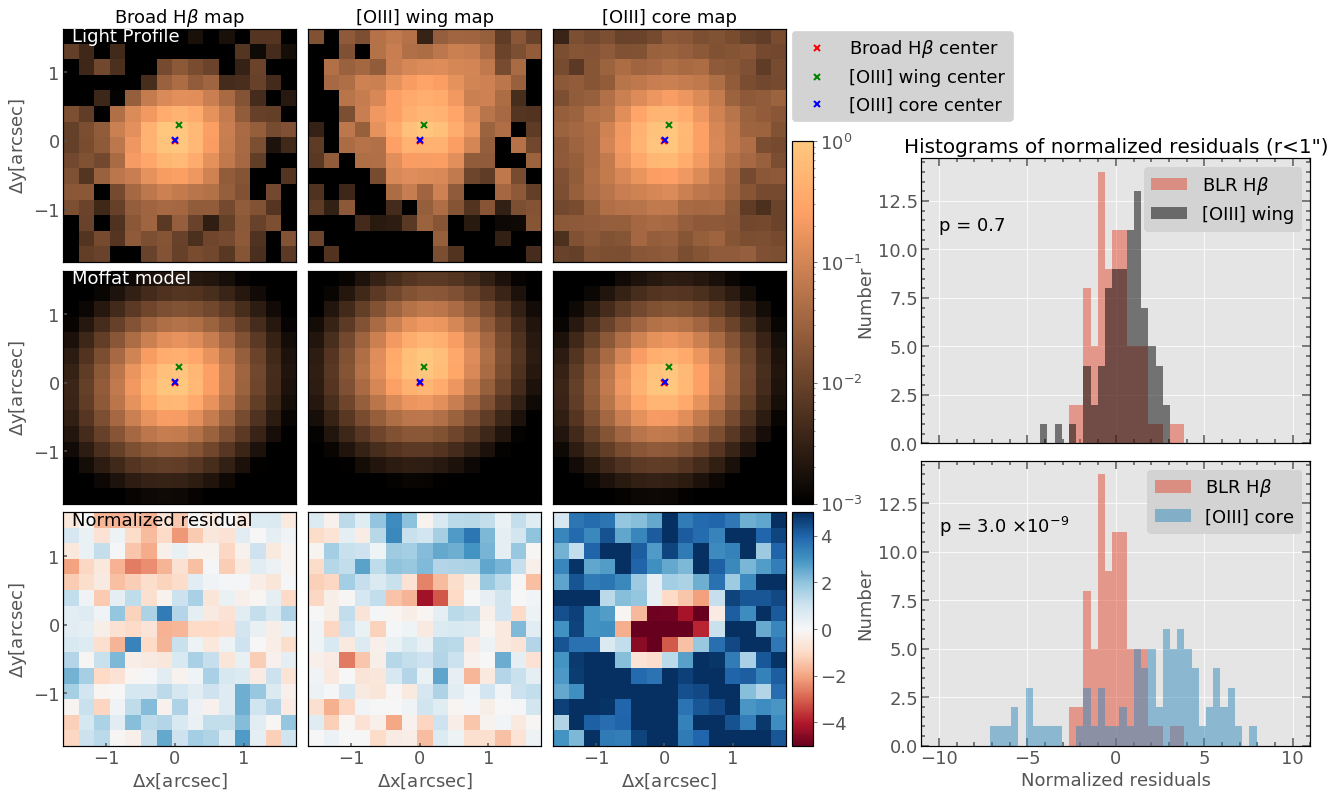

HE0119-0118
1.0598867172593058
[-0.028448486328125, -0.03476409912109375] [-0.0011425018310546875, -0.028168487548828128]
3
-3 0.7


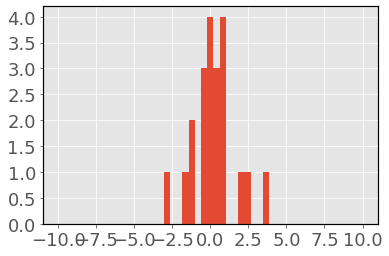

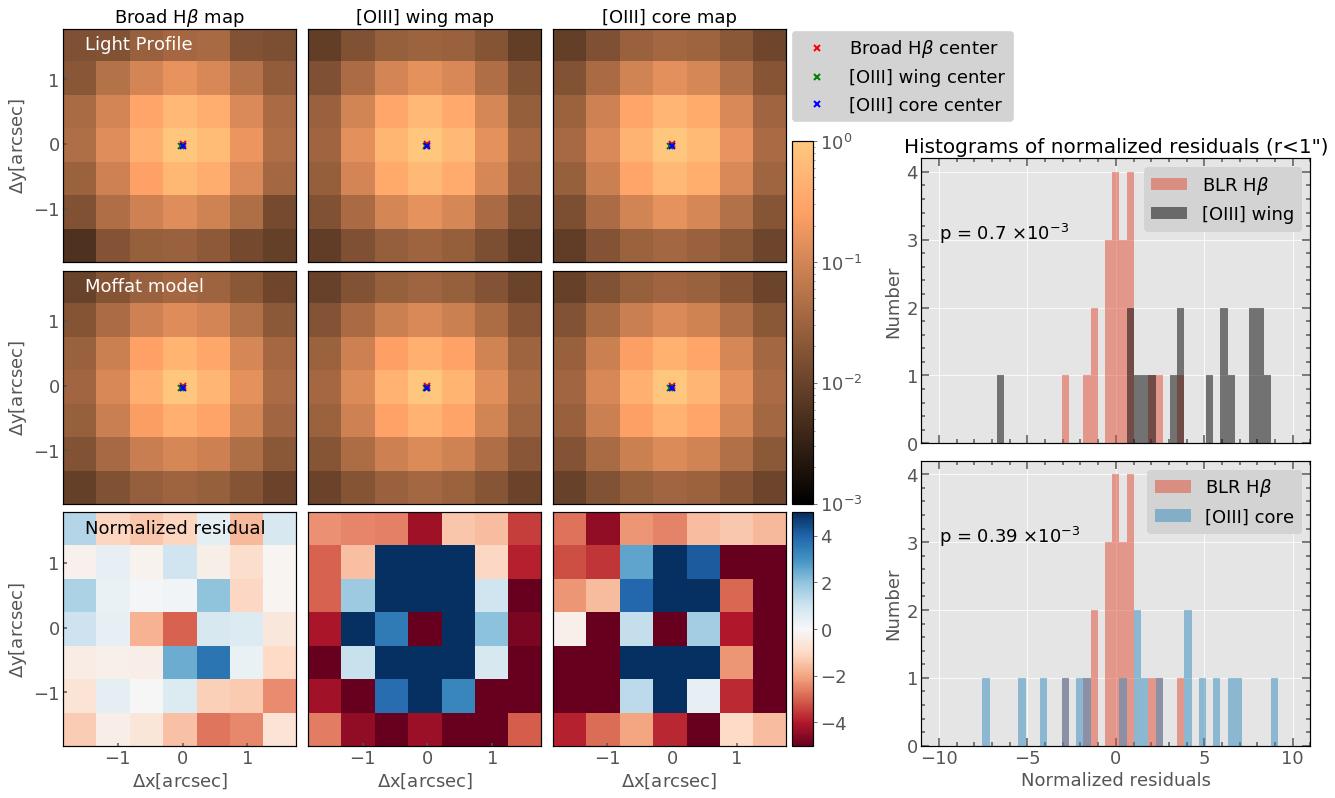

HE0212-0059
1.1697598427752396
[0.03428726196289063, 0.28472328186035156] [0.0028221130371093753, -0.012250518798828125]
13
-9 0.77


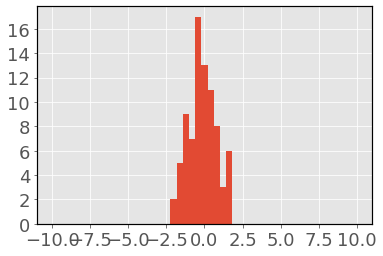

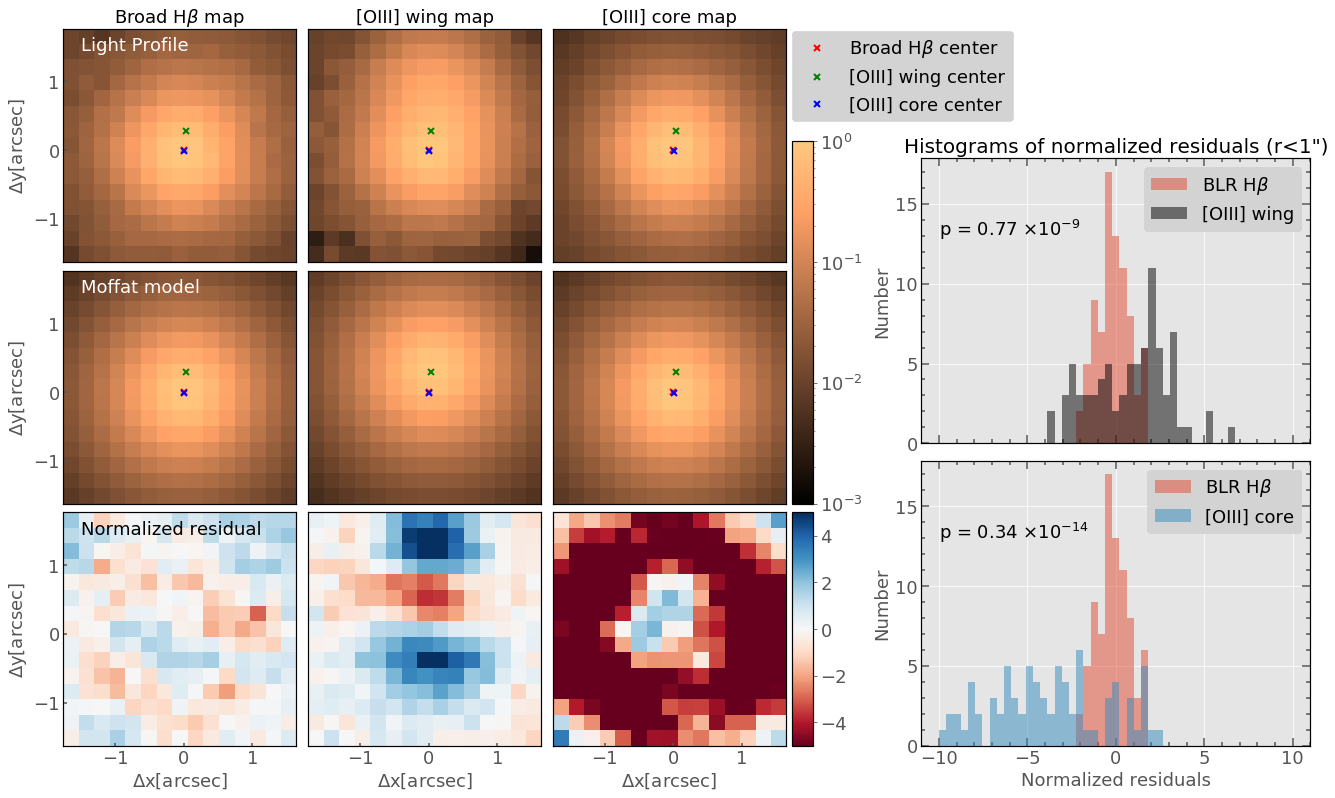

HE0224-2834
0.982931072177928
[0.020254898071289065, -0.027993392944335938] [-0.30636367797851566, 0.15377464294433596]
2
0 0.5


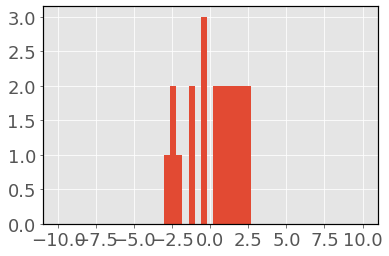

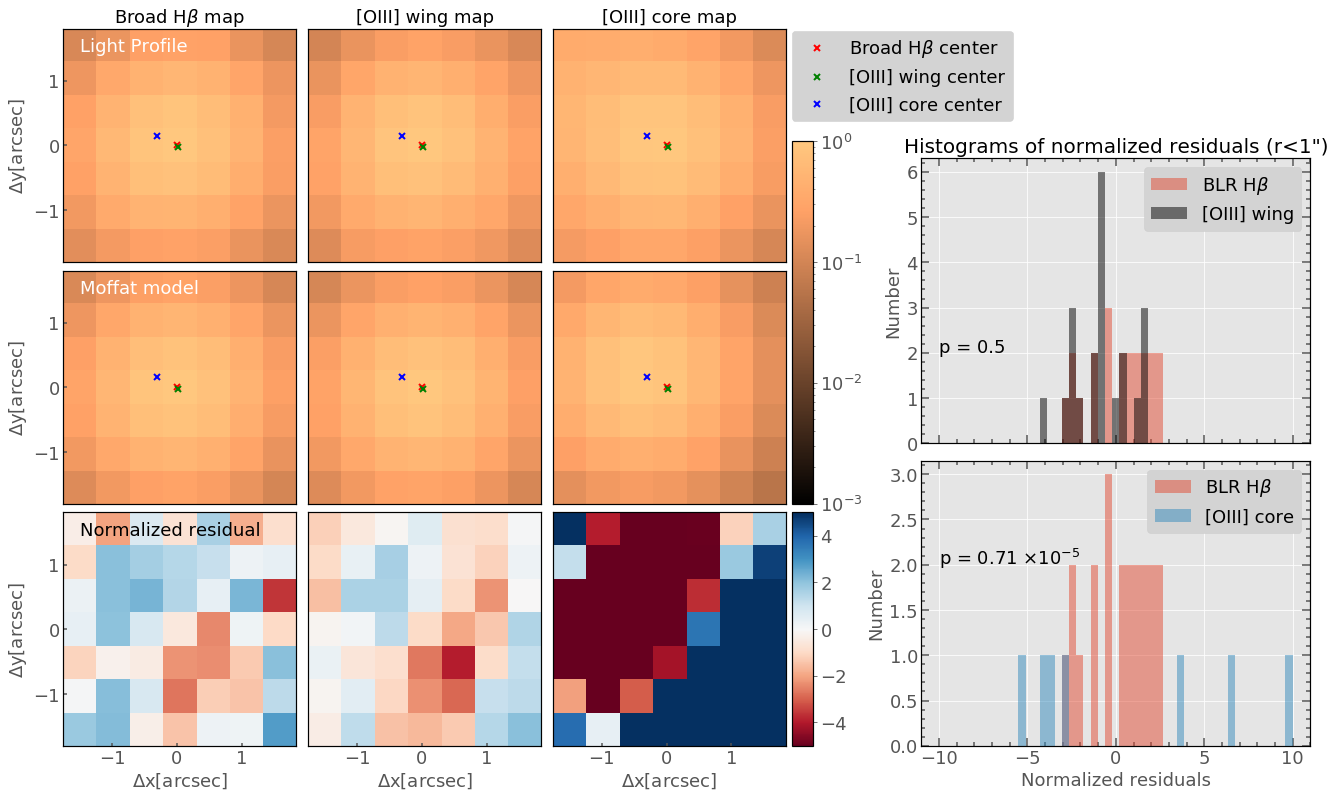

HE0227-0913
1.0496284950896089
[0.033659744262695315, 0.035776519775390626] [0.009821701049804689, 0.04531593322753907]
3
-3 1.04


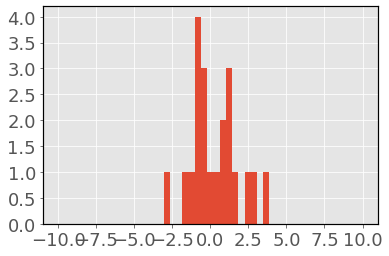

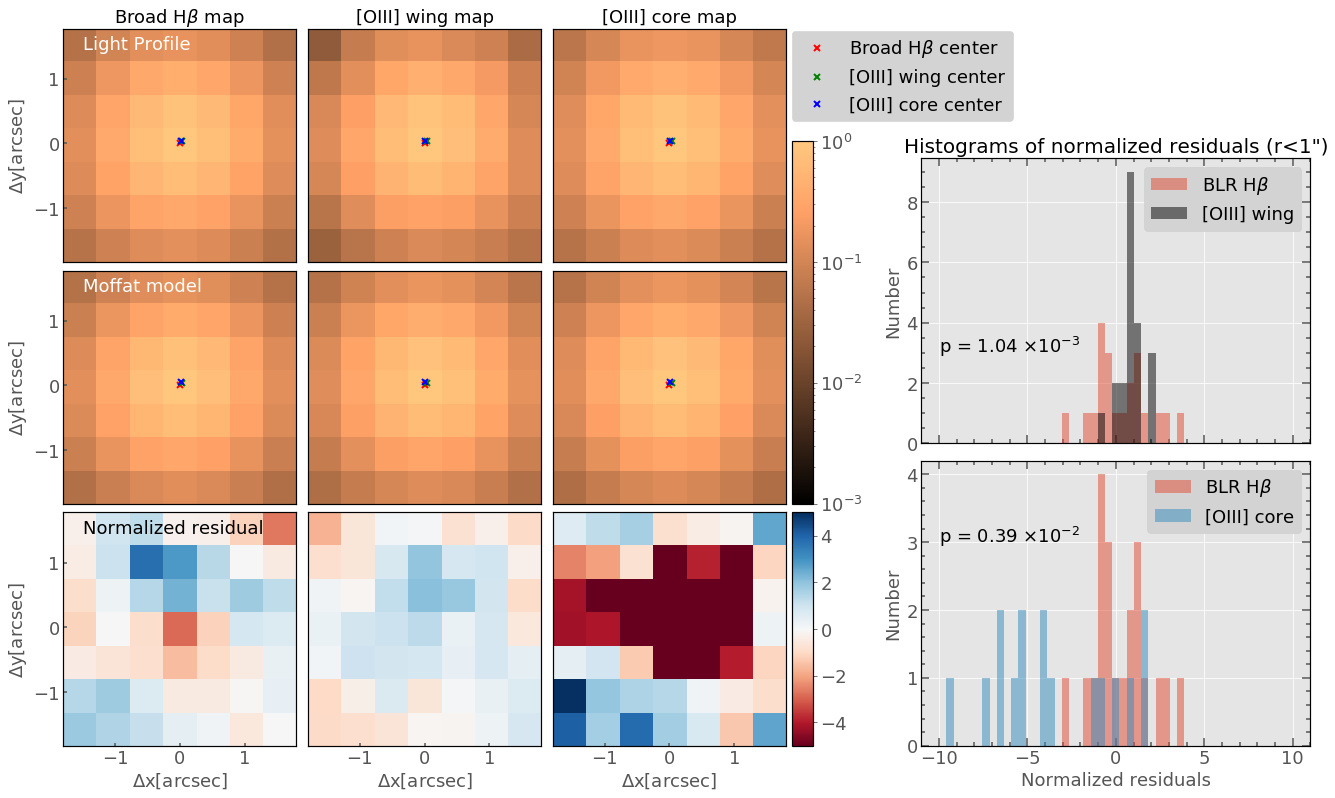

HE0232-0900
0.8654000440508832
[-0.17708435058593752, -0.06800079345703125] [-0.03180770874023438, -0.32441177368164065]
4
-5 1.76


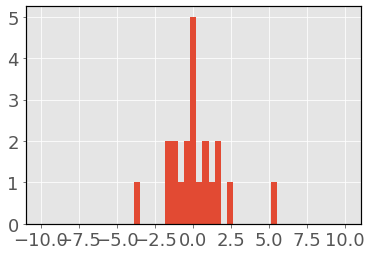

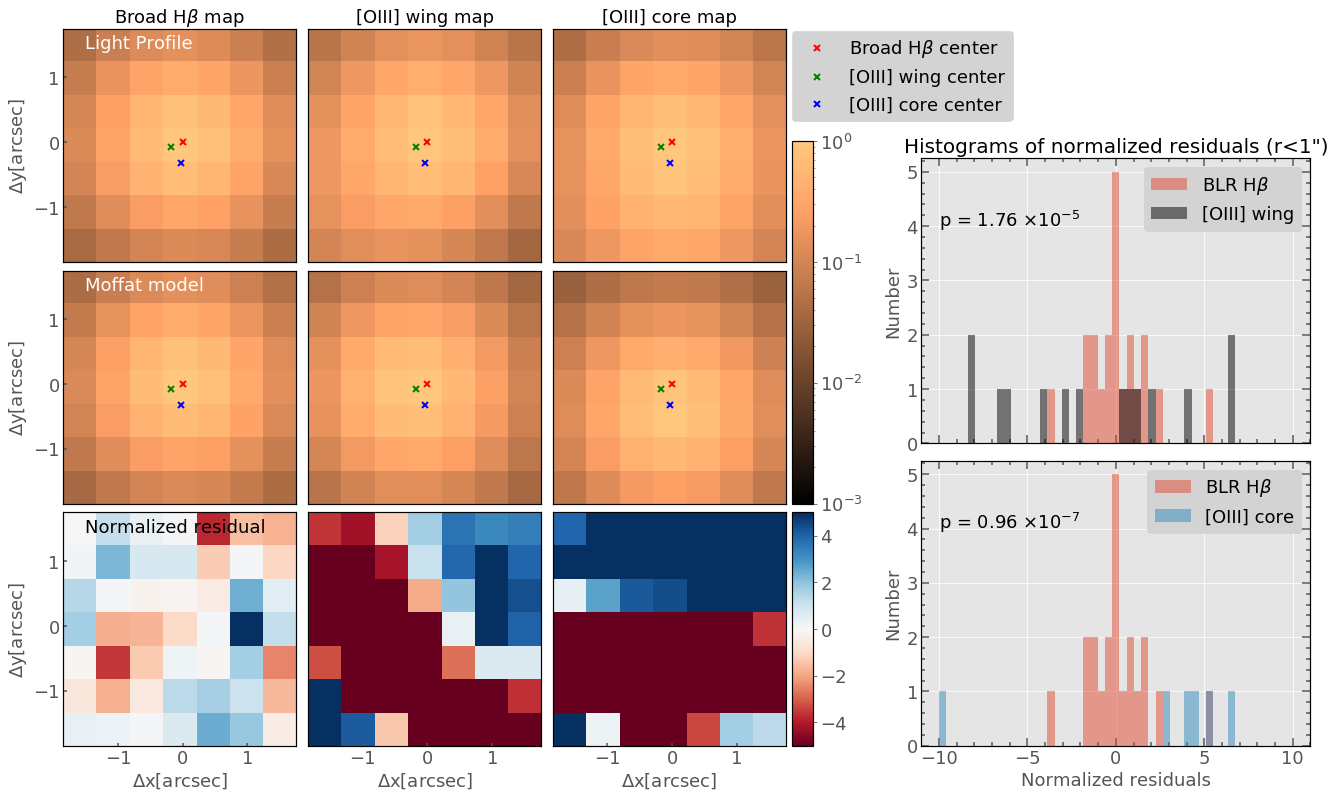

HE0253-1641
0.9888863602938999
[-0.025600433349609375, 0.01192474365234375] [-0.05325660705566407, -0.09250335693359375]
4
0 0.15


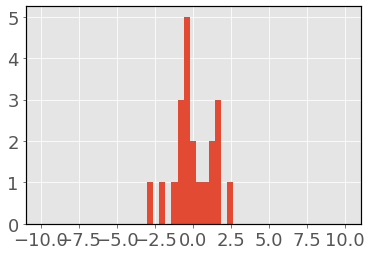

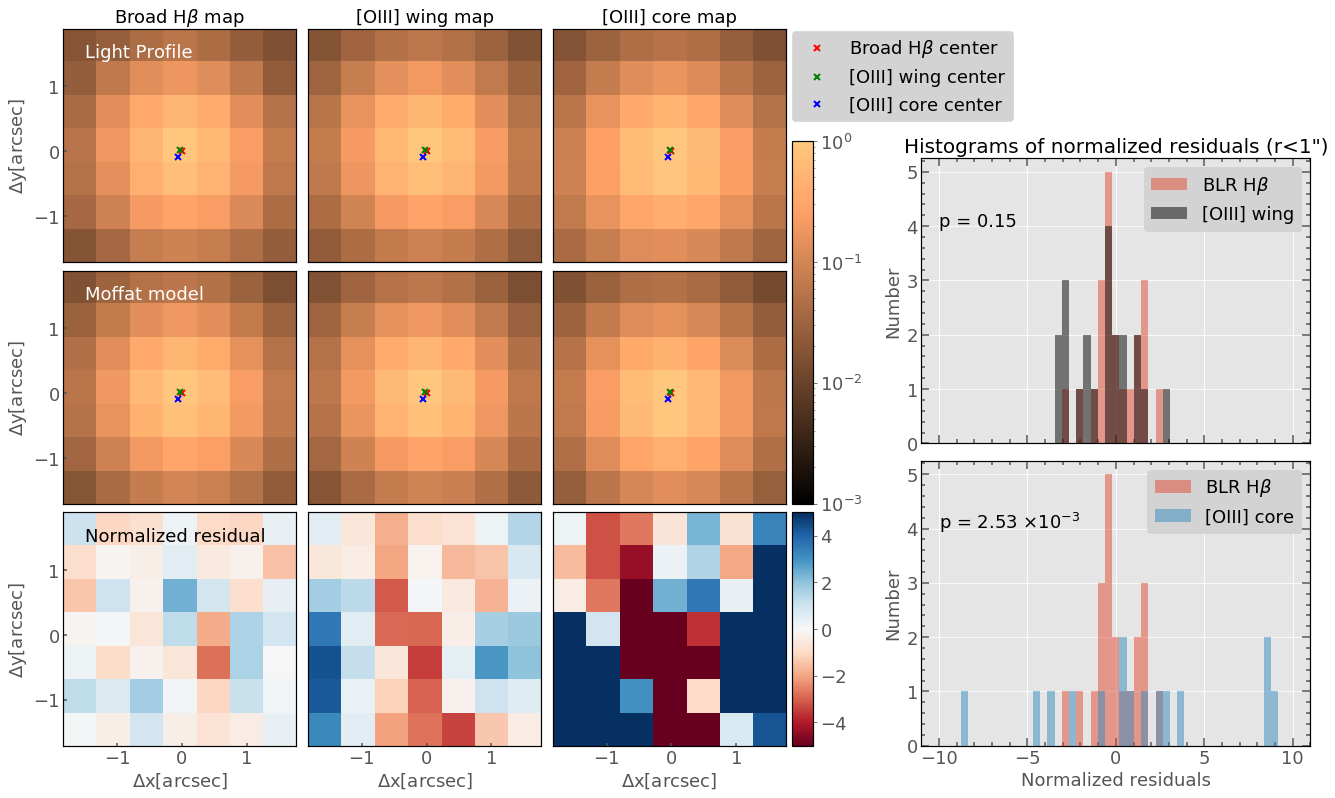

HE0345+0056
1.032160345821328
[0.0032470703125, -0.021452713012695315] [0.00099945068359375, -0.04443931579589844]
2
0 0.2


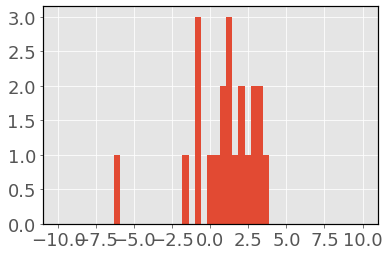

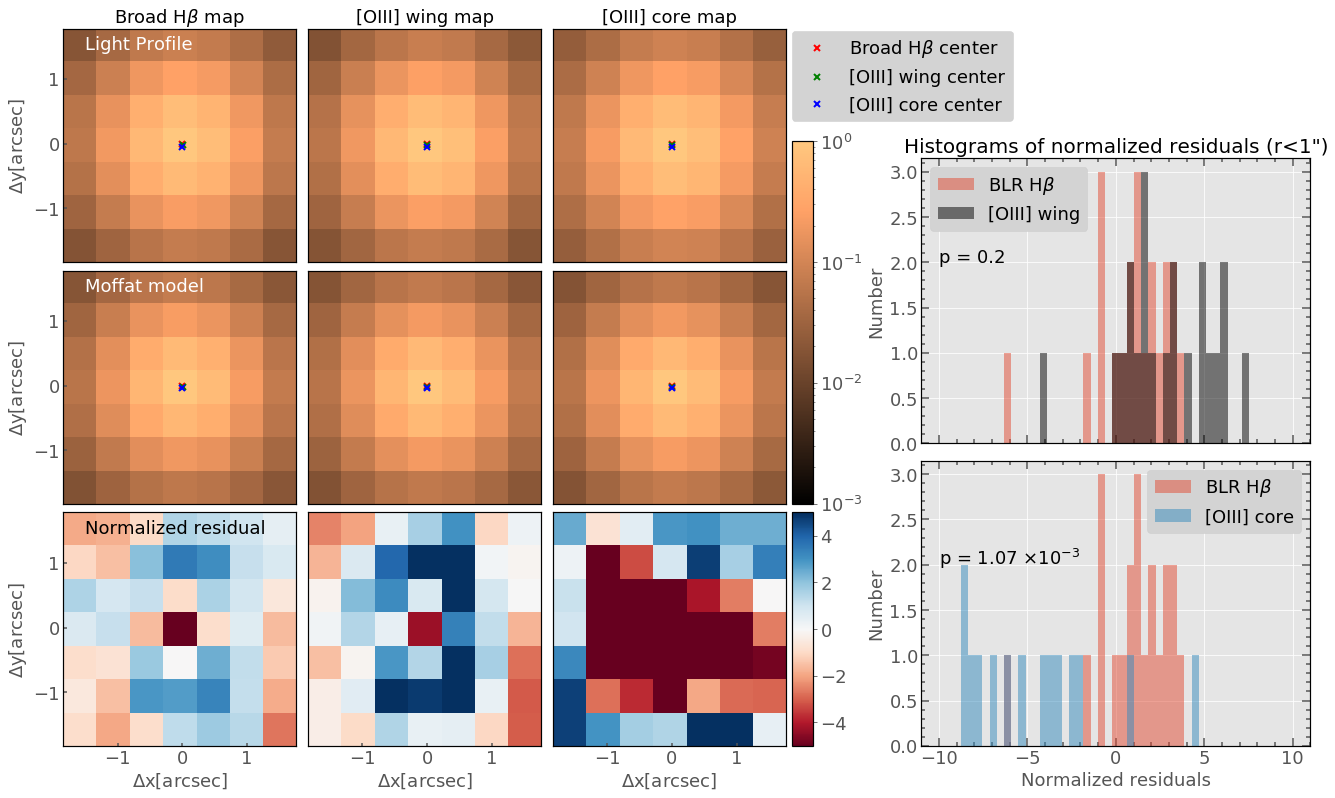

HE0351+0240
1.021963355472142
[-0.01179656982421875, 0.004206466674804688] [0.011072540283203126, -0.006451034545898438]
2
0 0.08


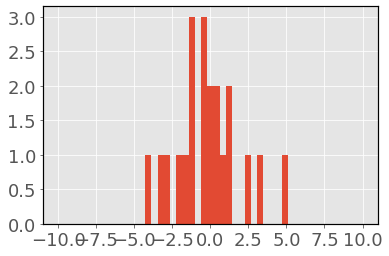

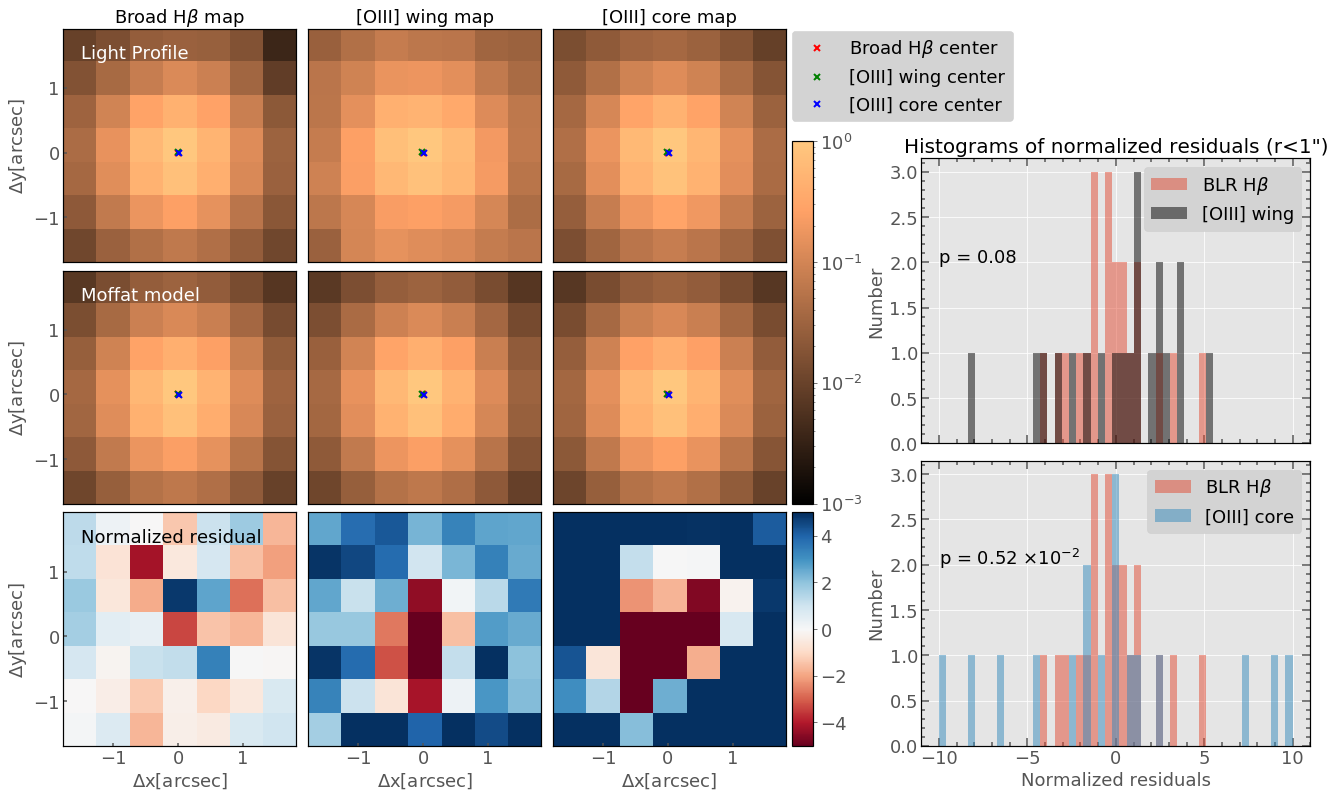

HE0412-0803
0.9572411044826732
[0.036688232421875, 0.005219268798828125] [0.0880126953125, 0.011442947387695314]
4
-6 0.35


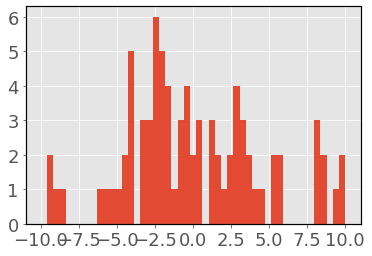

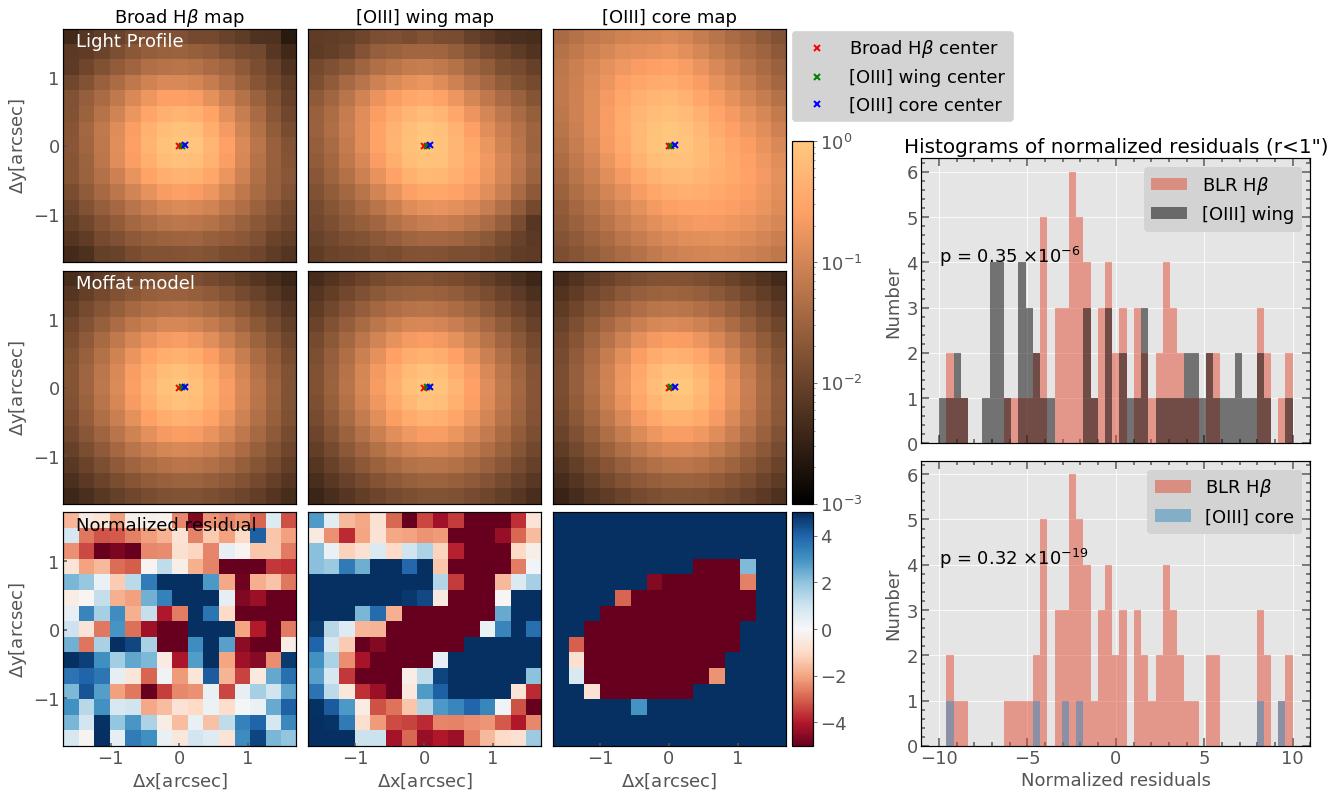

HE0429-0247
1.0232384524283233
[0.051190185546875, -0.009756469726562501] [-0.10009231567382813, 0.016895294189453125]
3
0 0.16


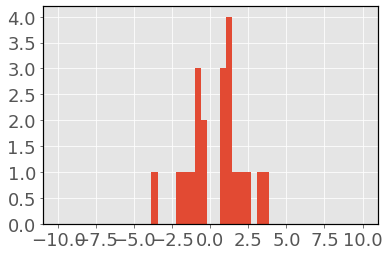

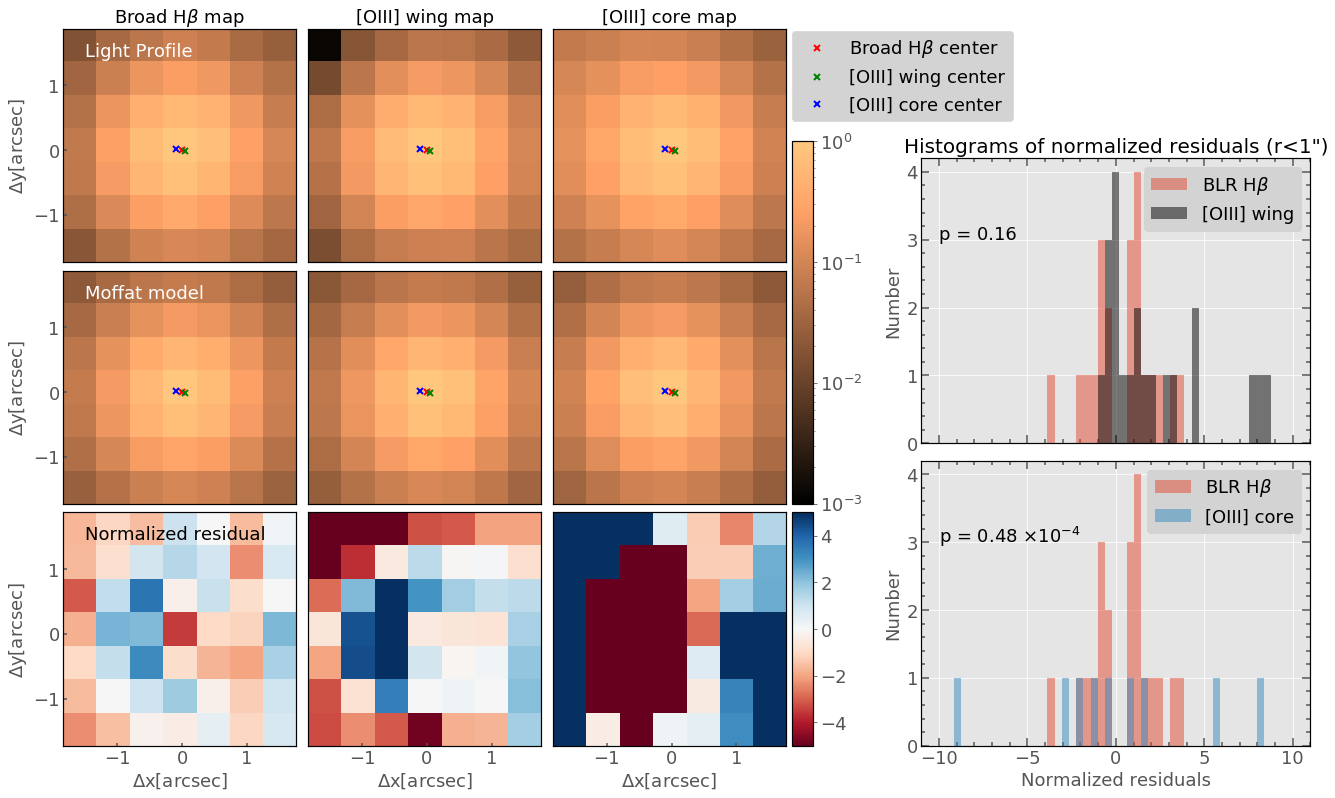

HE0433-1028
1.0083001036644994
[0.01856689453125, -0.018590927124023438] [0.009029388427734375, 0.018259048461914062]
8
-3 1.73


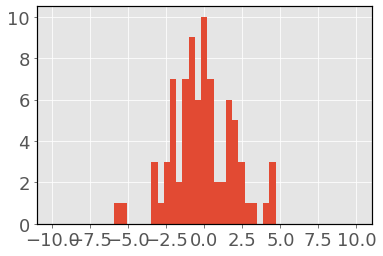

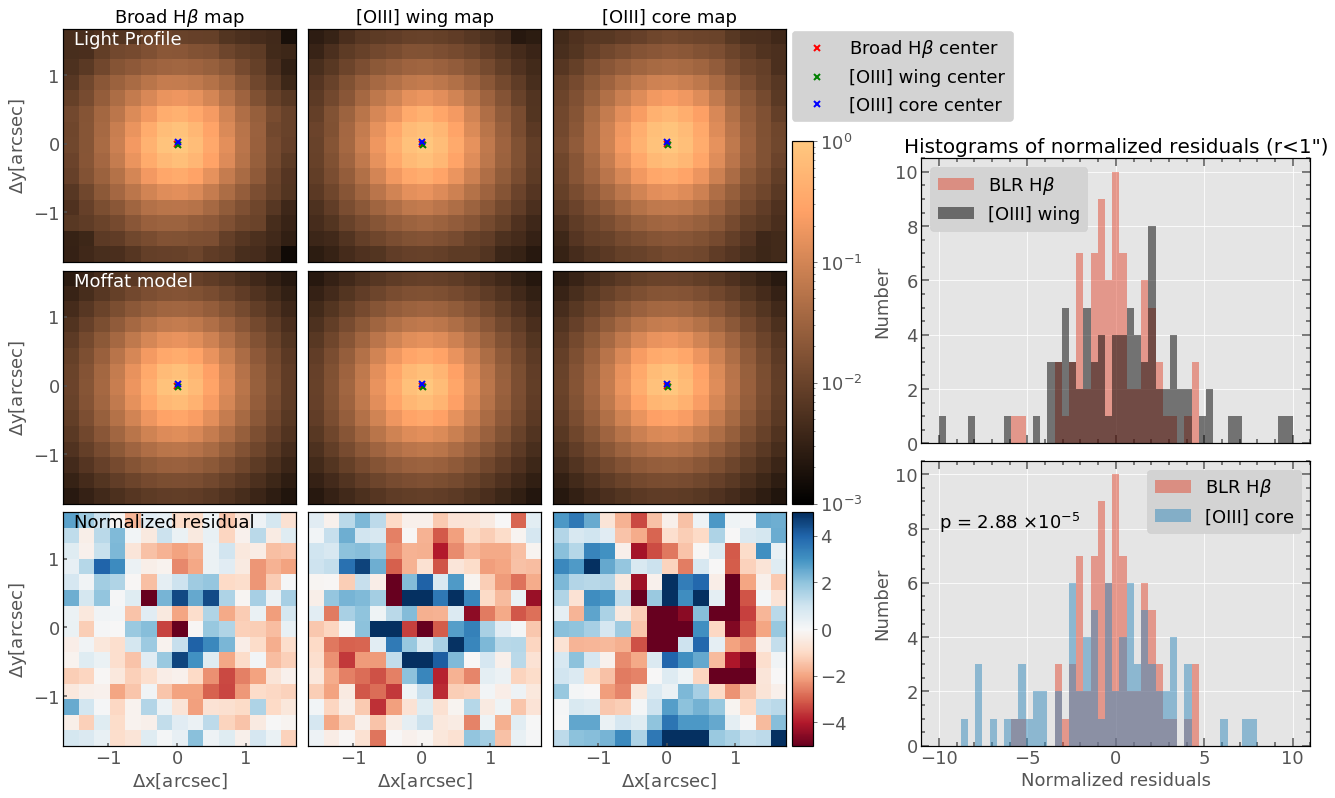

HE0853+0102
1.0609639358763707
[0.007511138916015625, -0.012613296508789062] [0.04146270751953125, 0.035284805297851565]
8
0 0.42


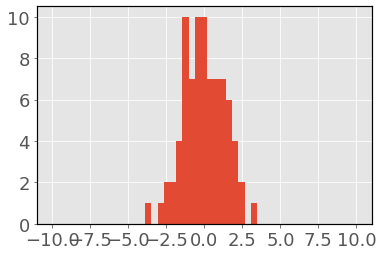

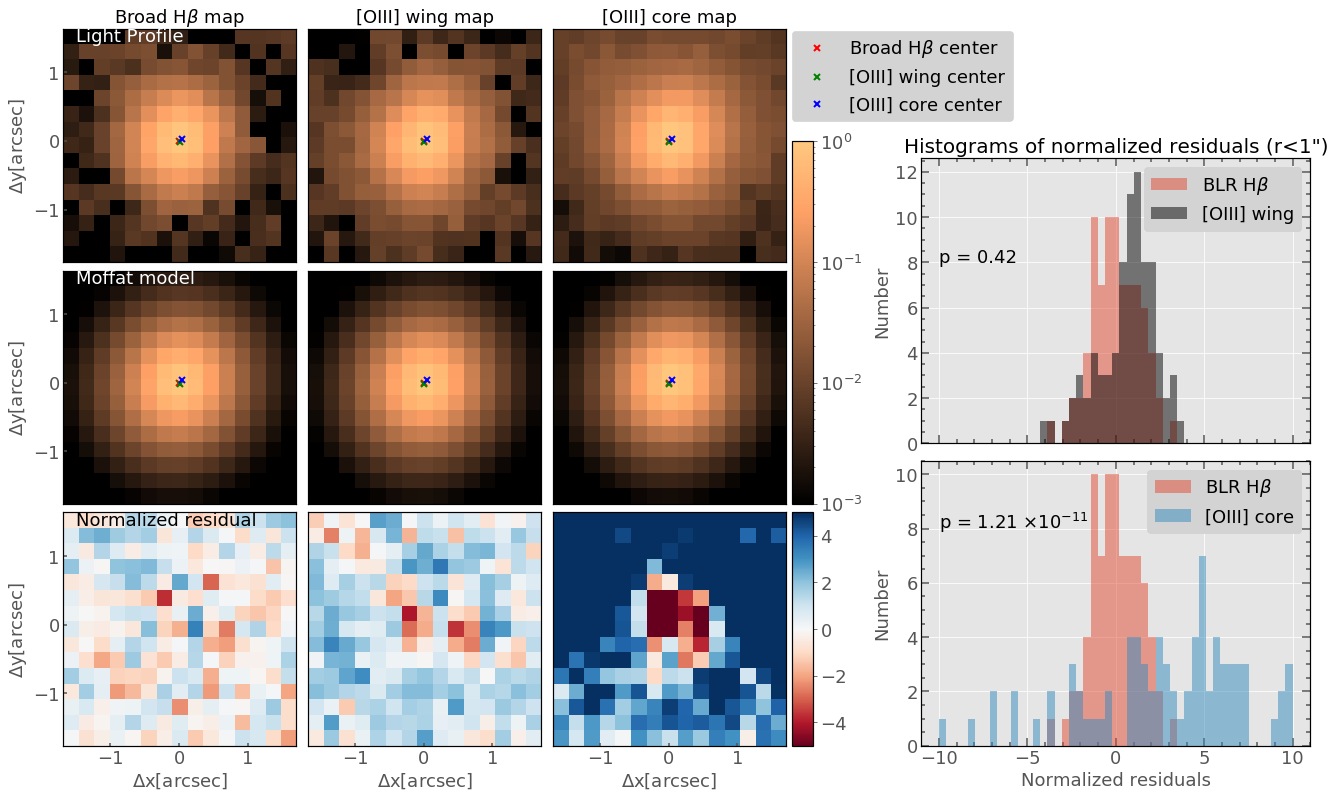

HE0934+0119
0.9962574648735392
[0.019525527954101562, -0.031167602539062502] [-0.018235015869140624, 0.0073394775390625]
16
-1 0.73


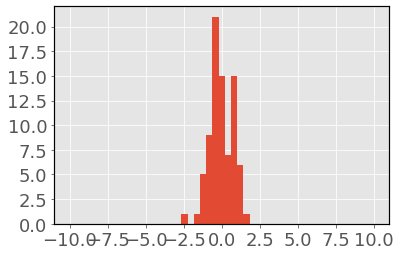

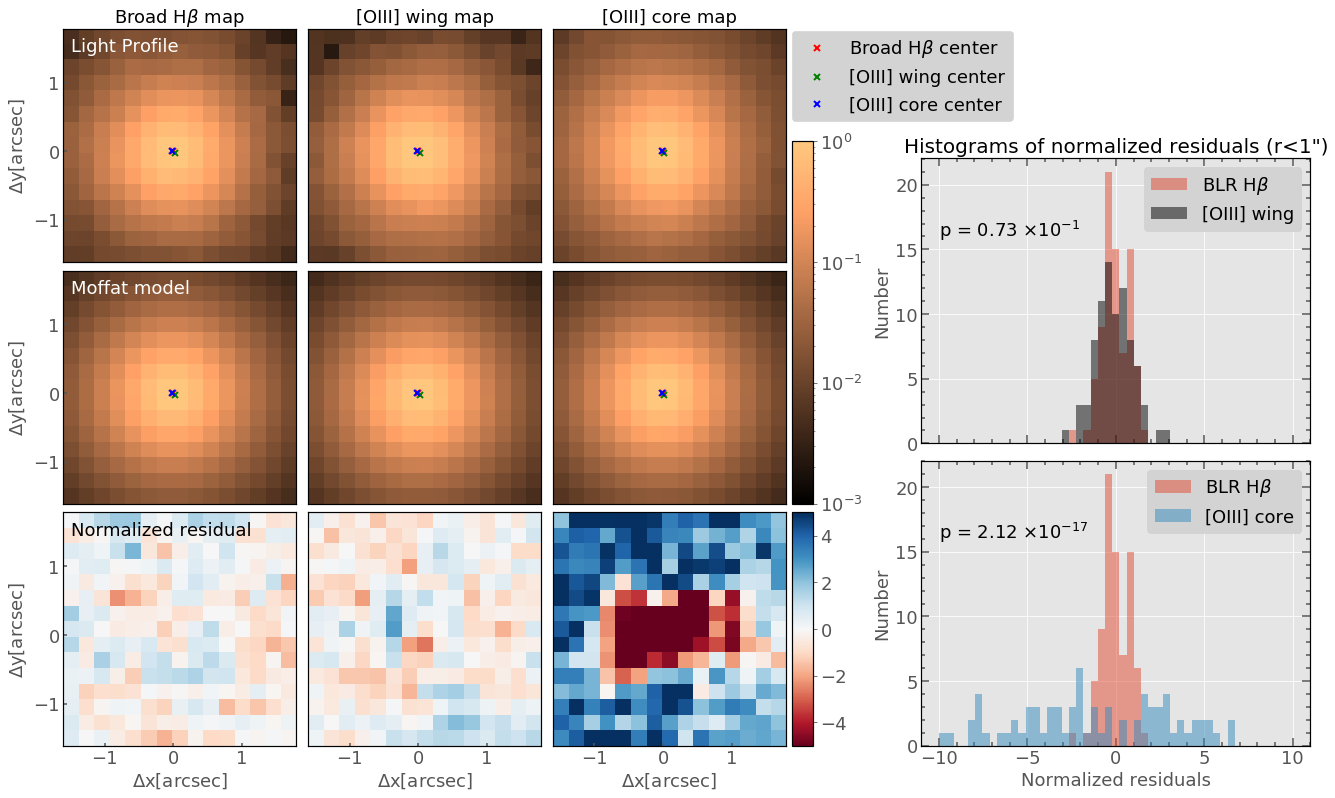

HE1011-0403
1.0088562291682384
[0.013076019287109376, -0.0016841888427734375] [-0.006098937988281251, -0.010760116577148439]
8
0 0.68


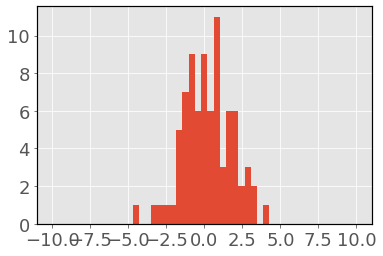

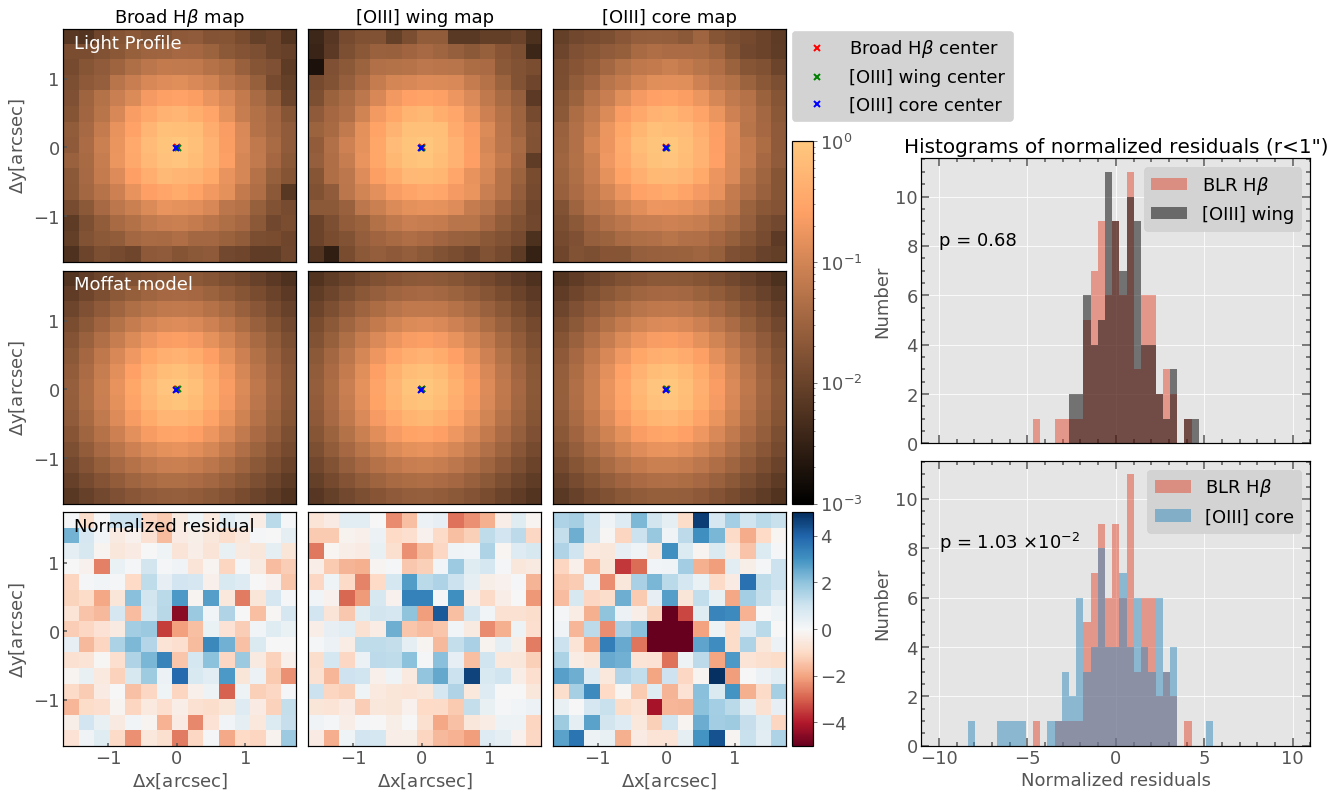

HE1017-0305
1.017637116000711
[0.0117523193359375, -0.032982254028320314] [-0.009367752075195314, 0.012914276123046875]
6
-2 0.99


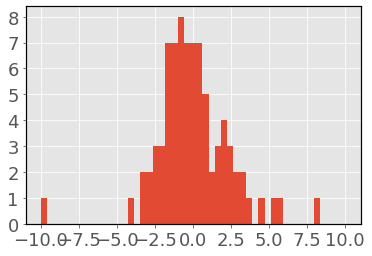

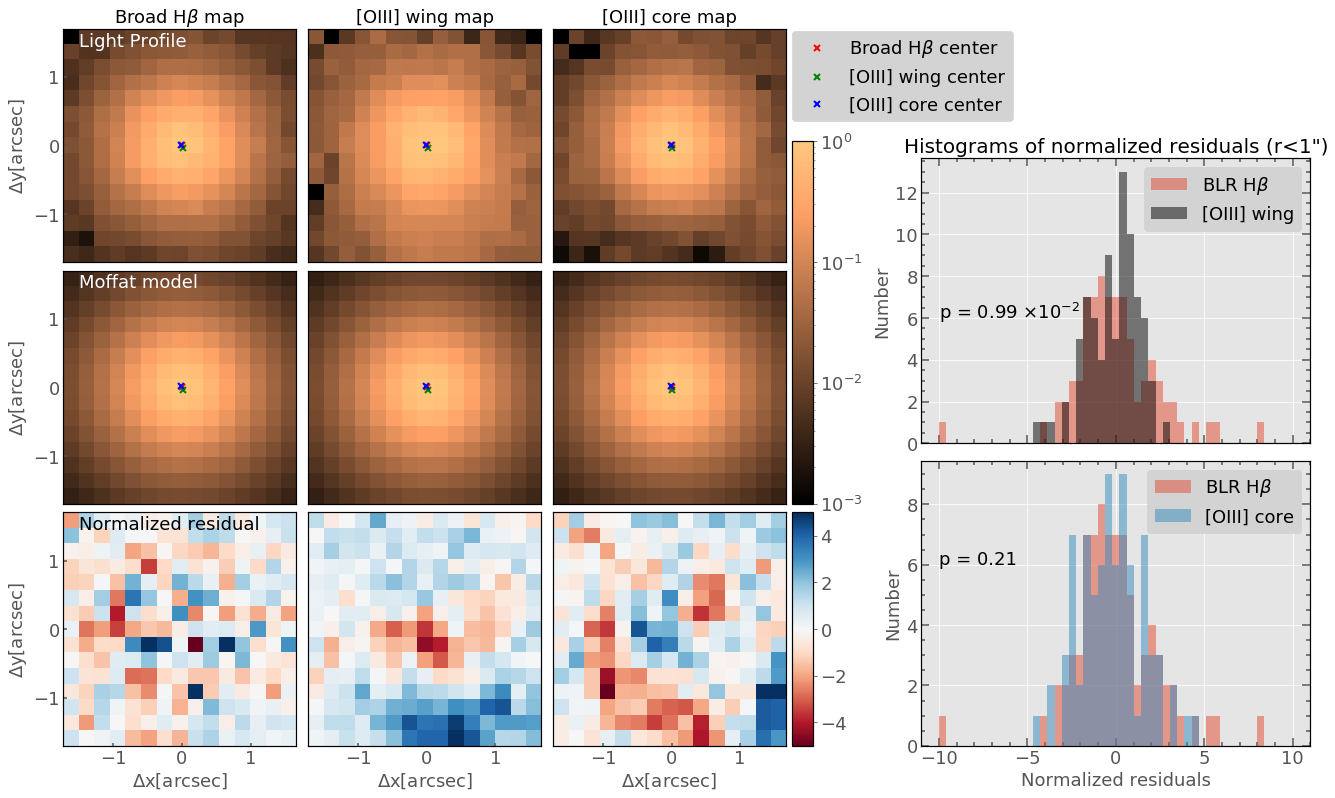

HE1029-1831
1.0367447424208138
[-0.050066375732421876, 0.05777091979980469] [0.08715476989746095, -0.028327178955078126]
13
-8 3.06


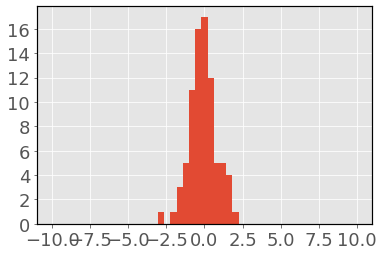

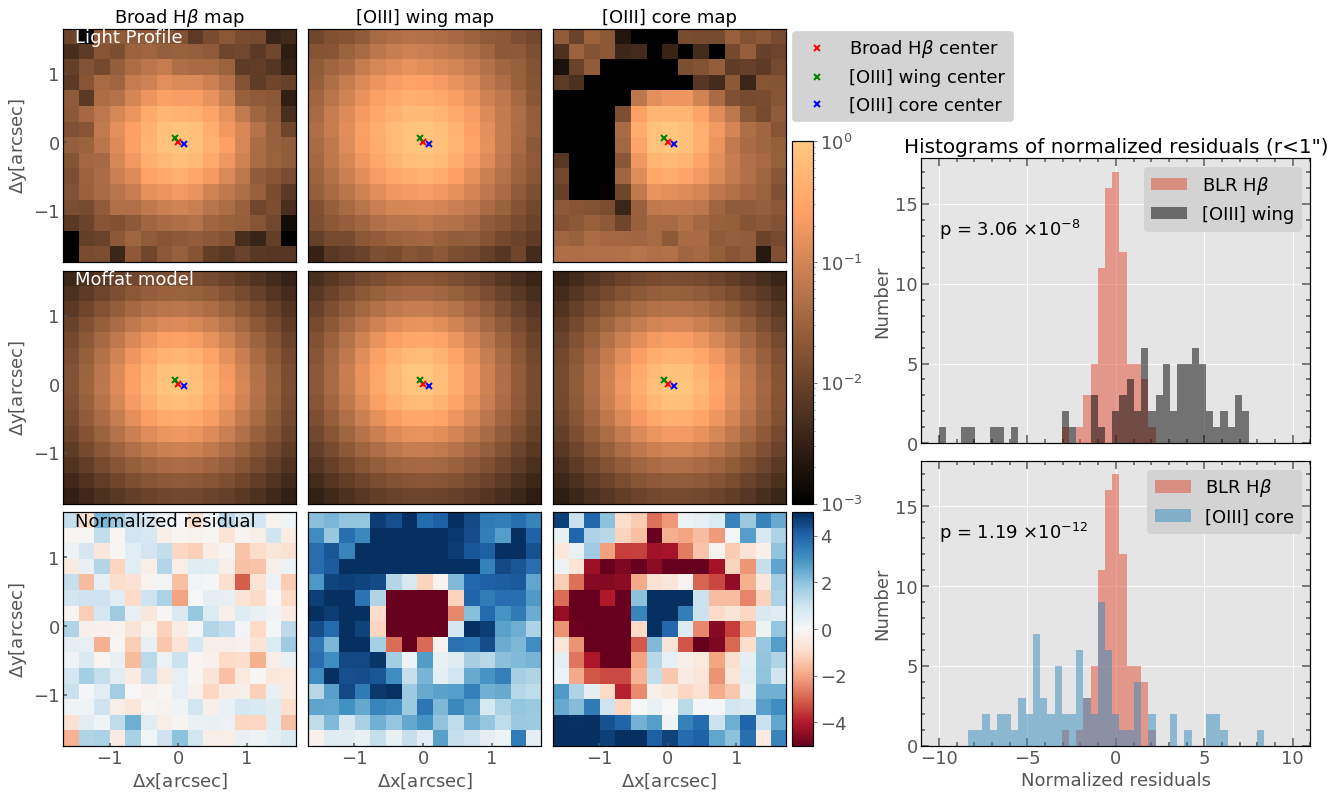

HE1107-0813
1.004413102707633
[0.034972763061523436, 0.012052536010742188] [-0.16308174133300782, -0.06414451599121095]
11
0 0.47


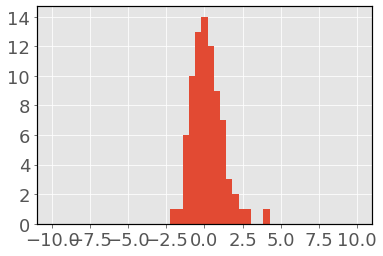

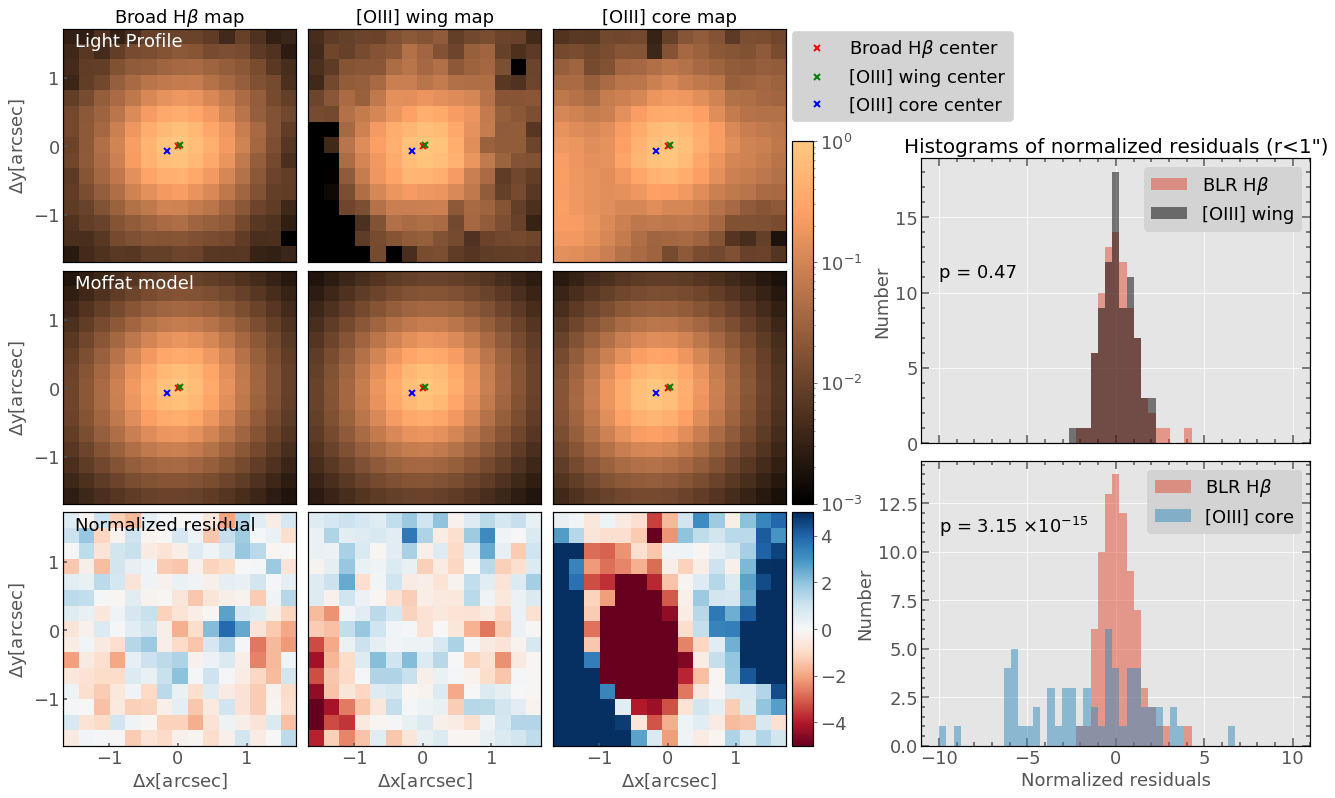

HE1108-2813
1.049704801292731
[0.059703063964843754, 0.004853057861328125] [0.06344490051269532, -0.008536148071289064]
8
0 0.79


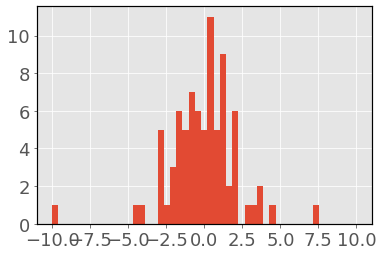

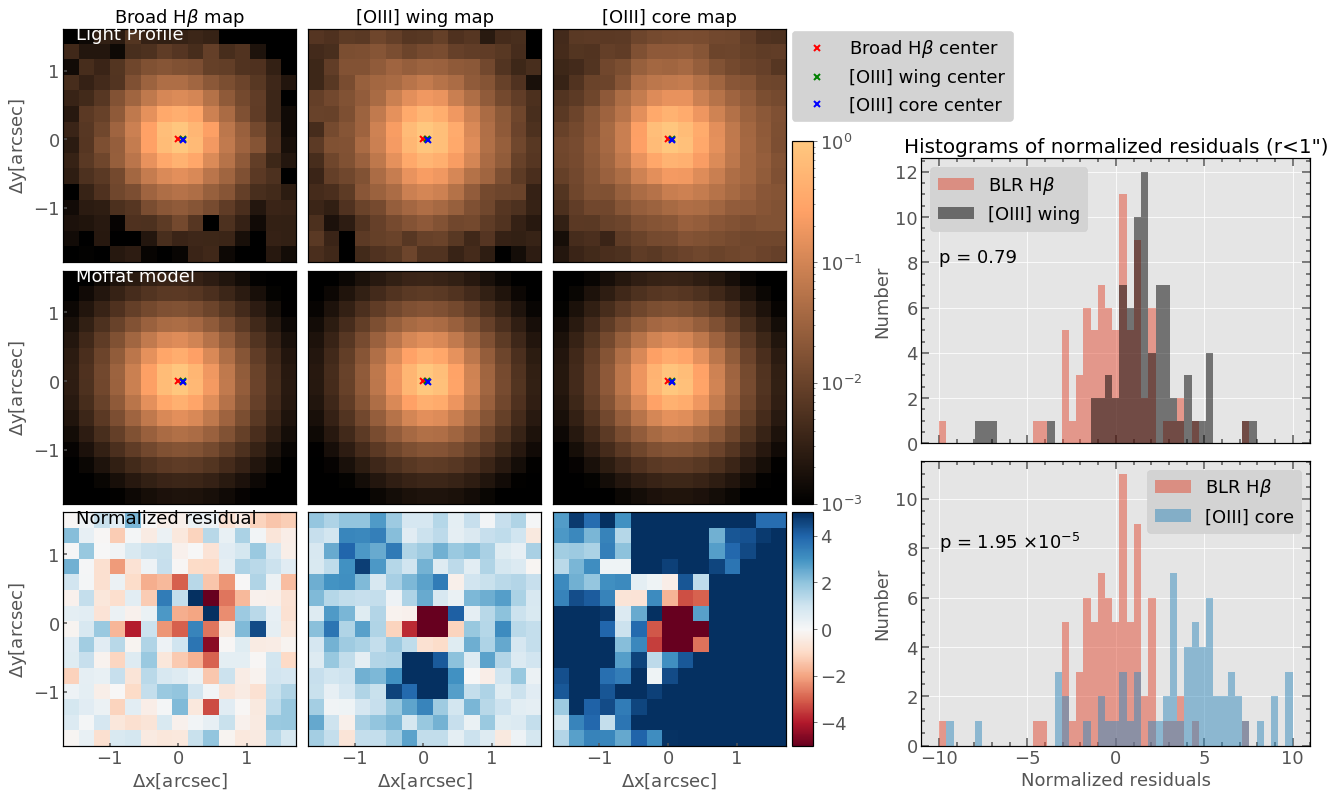

HE1126-0407
1.0255345885544729
[0.028108596801757812, -0.000275421142578125] [0.06942024230957032, 0.13646430969238282]
5
0 0.63


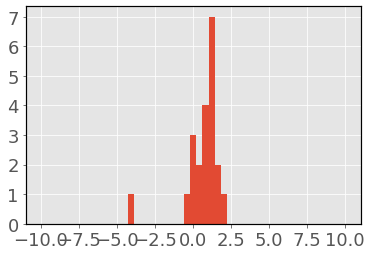

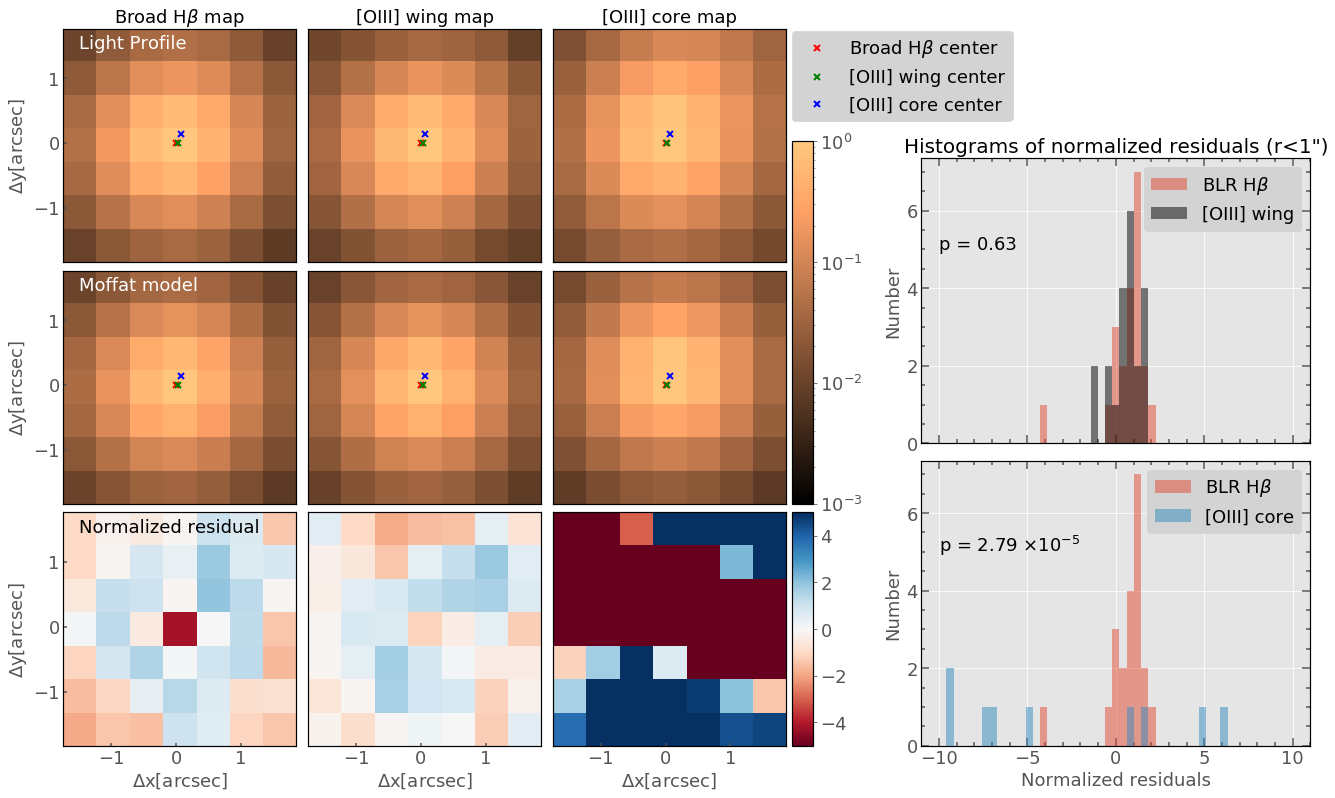

HE1237-0504
1.0154367239422113
[-0.033769989013671876, -0.005942535400390626] [0.08185653686523438, 0.017209243774414063]
4
0 0.02


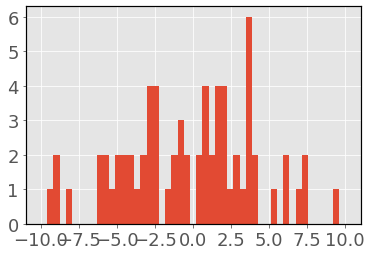

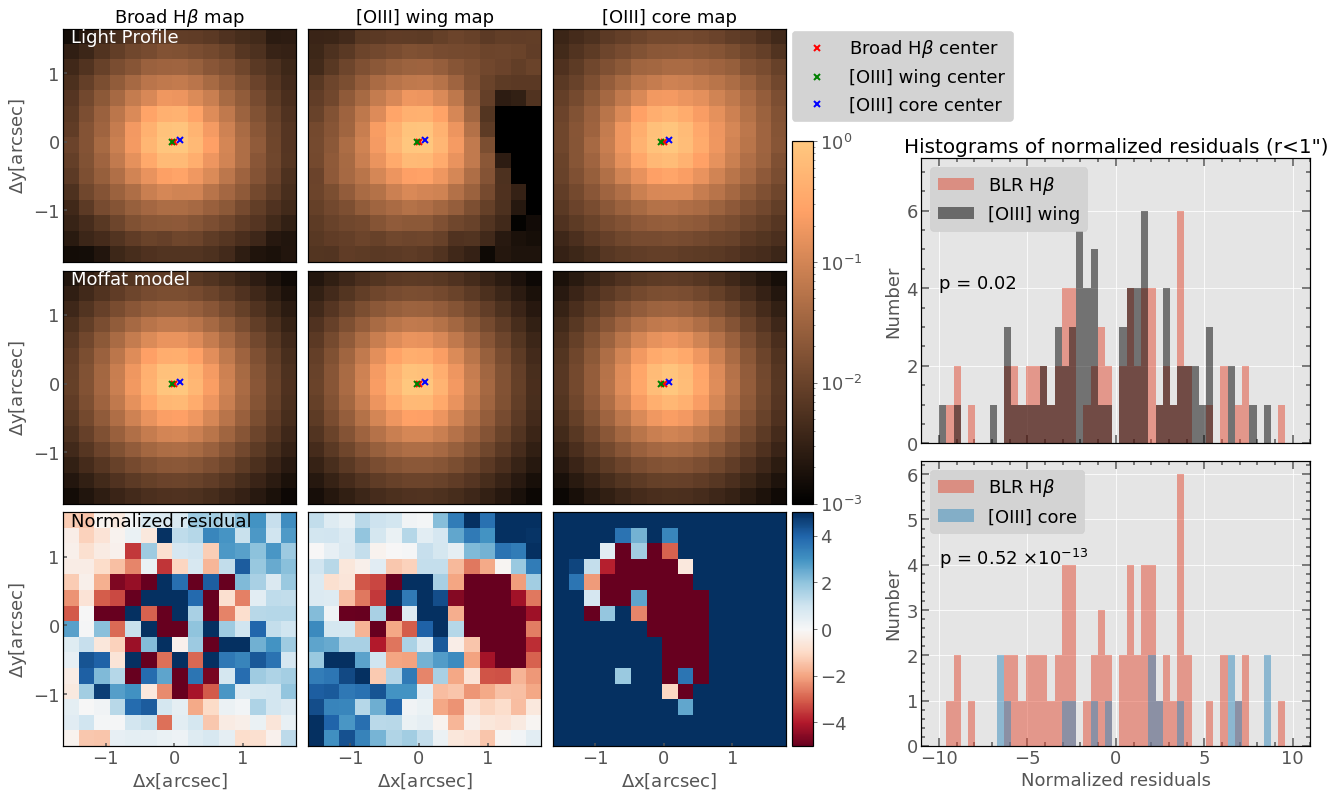

HE1248-1356
1.3902459959970808
[0.0228729248046875, -0.0201751708984375] [0.06482582092285157, -0.009832382202148438]
11
-6 0.65


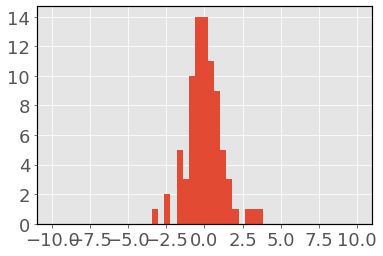

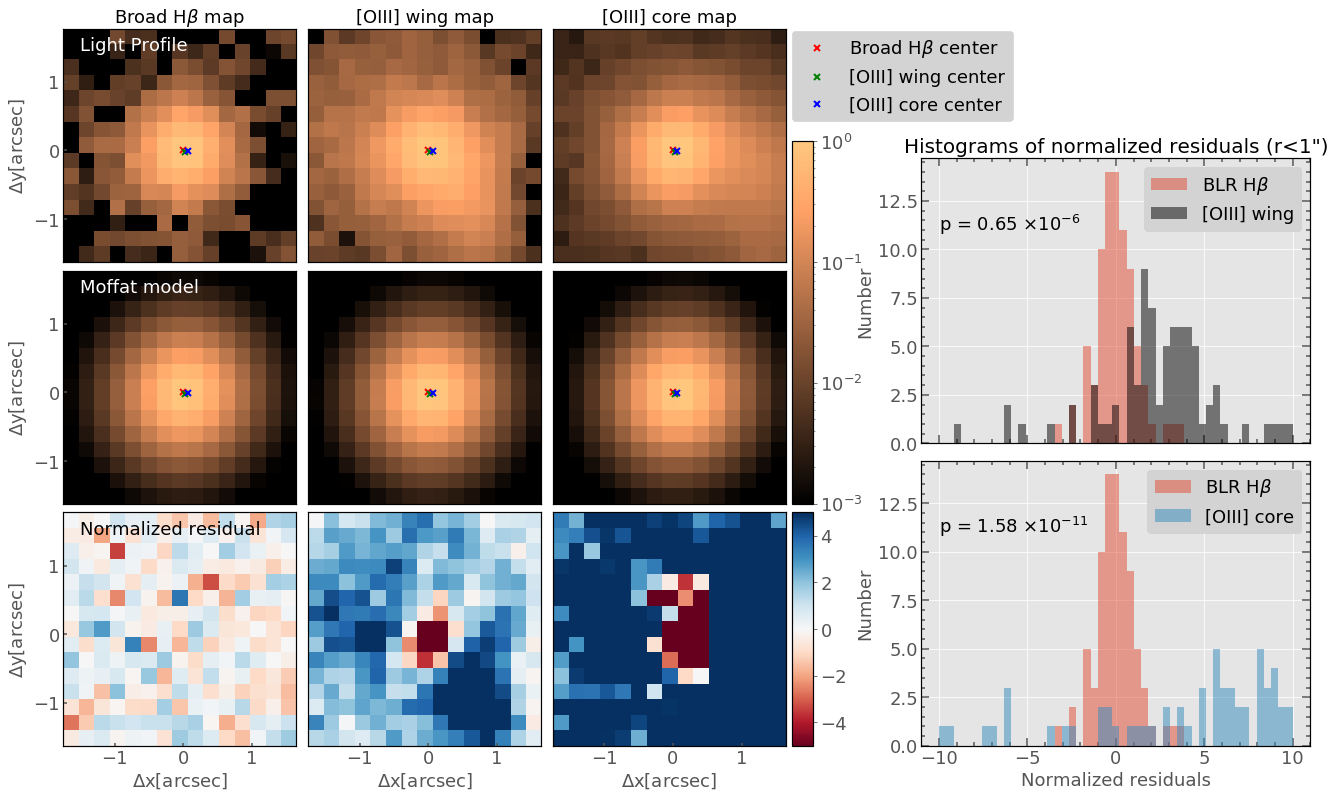

HE1330-1013
0.9999057538800731
[-0.03206329345703125, 0.04064369201660156] [0.03560066223144531, -0.04277114868164063]
13
0 0.75


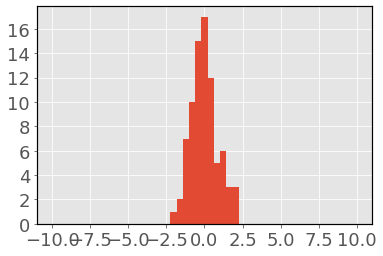

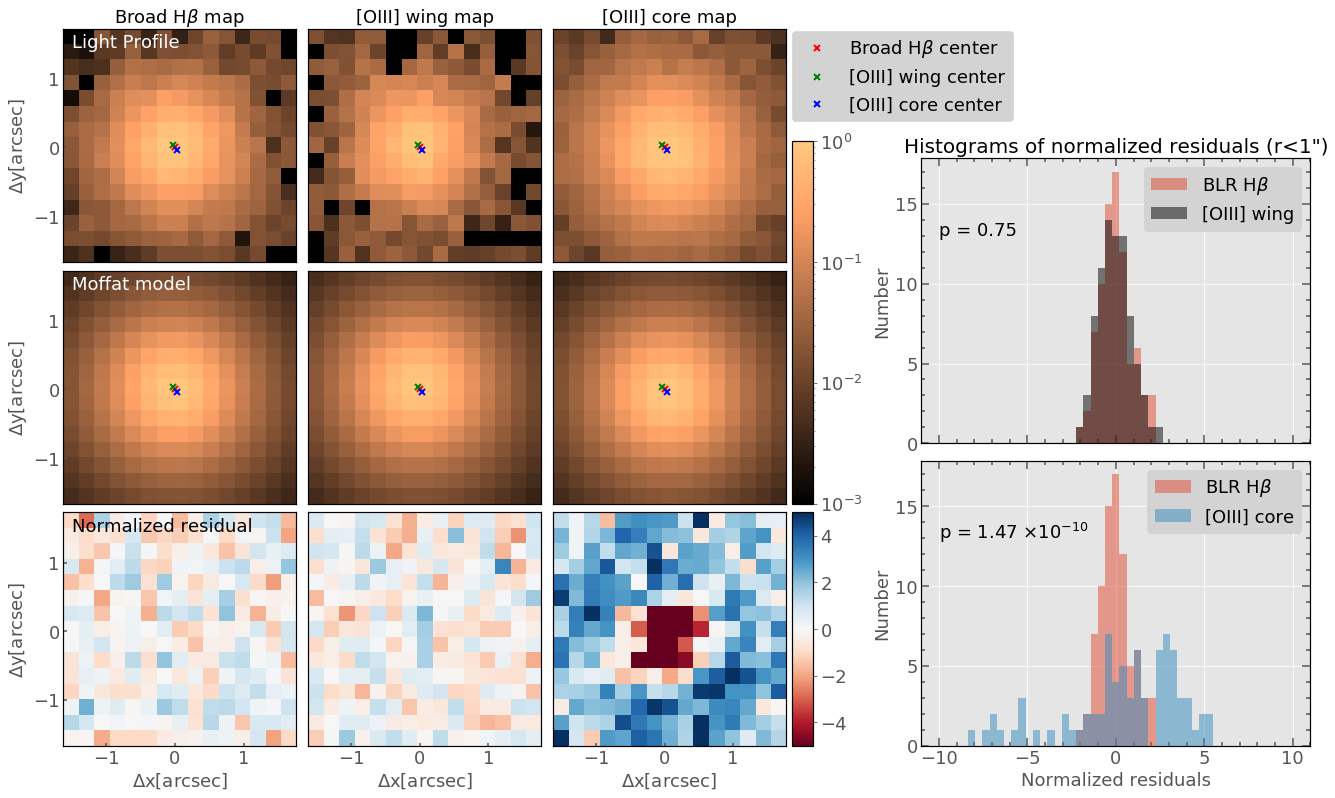

HE1353-1917
1.7497813670329212
[0.6199760437011719, -0.9079631805419922] [-0.0117034912109375, 0.32845916748046877]
11
-13 2.76


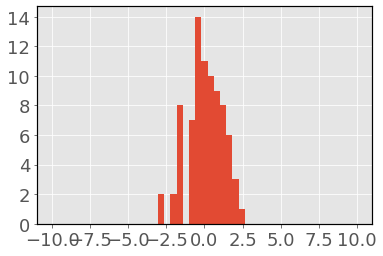

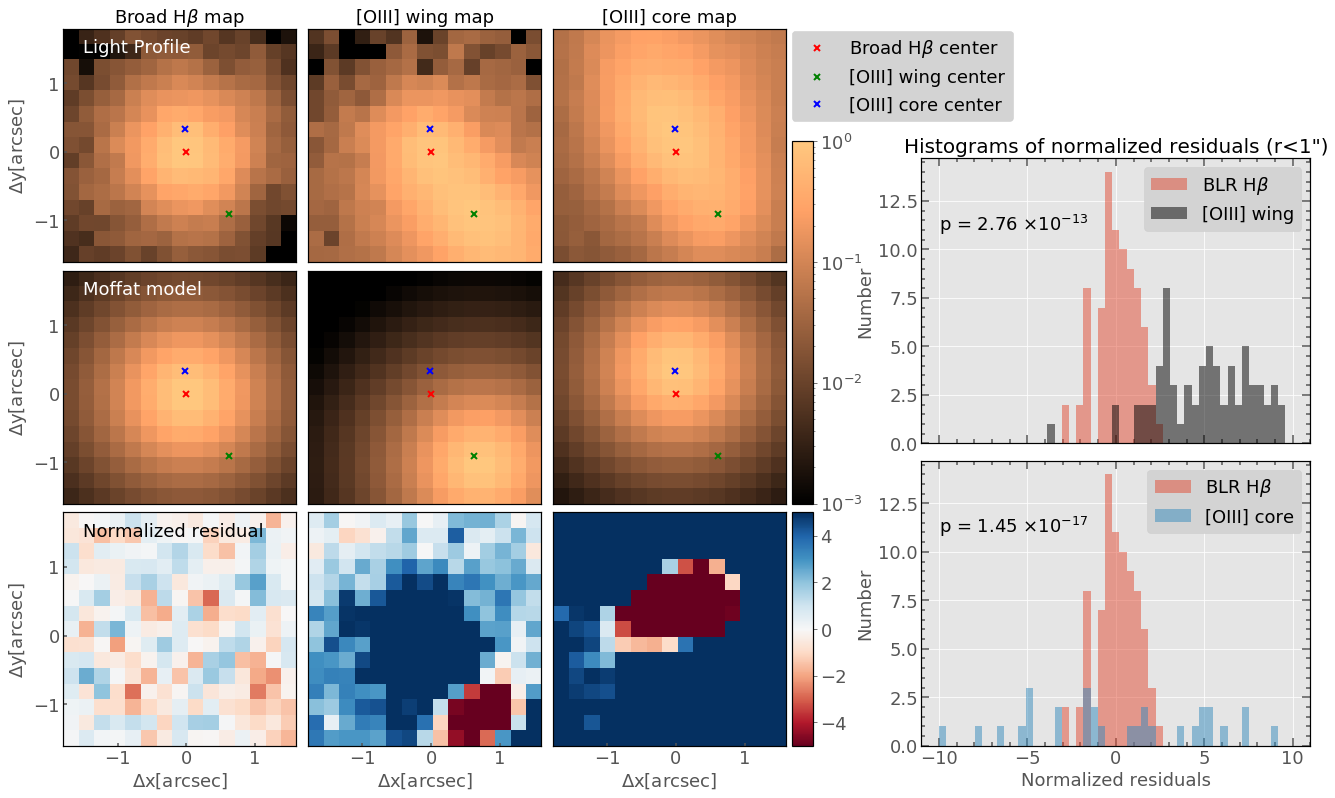

HE1417-0909
0.9635594600001948
[0.03815155029296875, -0.023919677734375002] [0.00421295166015625, 0.007304382324218751]
2
0 0.18


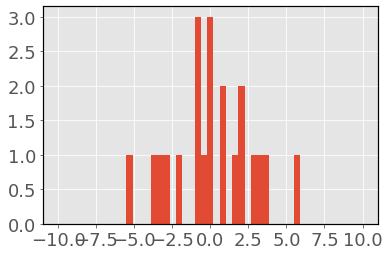

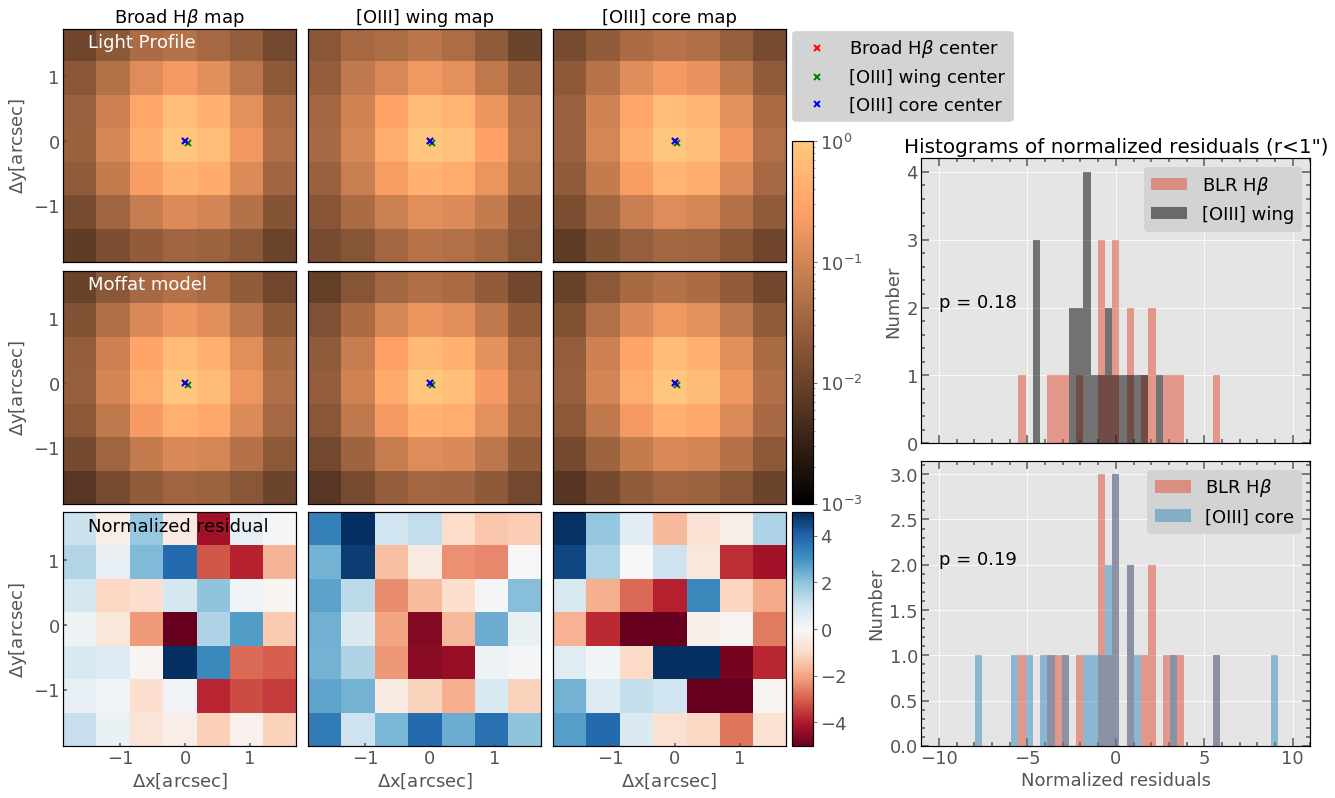

HE2128-0221
1.0087431328852996
[0.0036632537841796878, 0.030526351928710938] [0.009129333496093751, 0.04878768920898438]
11
0 0.17


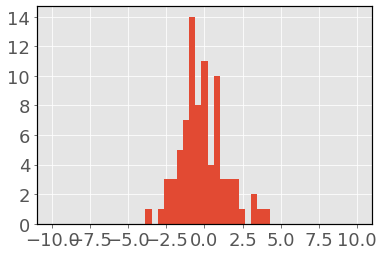

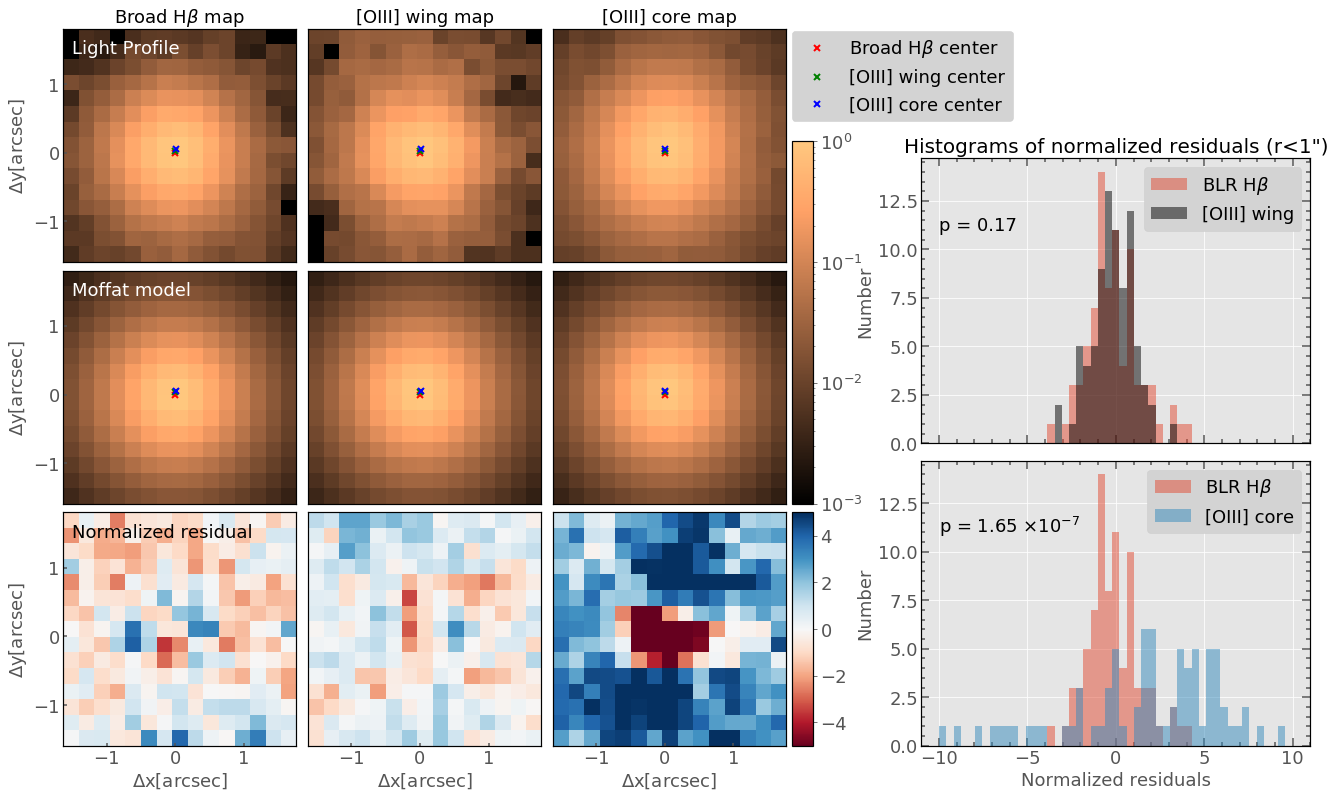

HE2211-3903
1.0813114578045666
[0.03573532104492188, 0.05483970642089844] [-0.006209945678710938, 0.041566467285156256]
8
-1 0.61


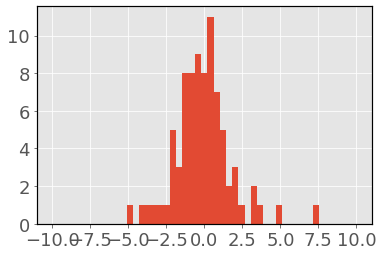

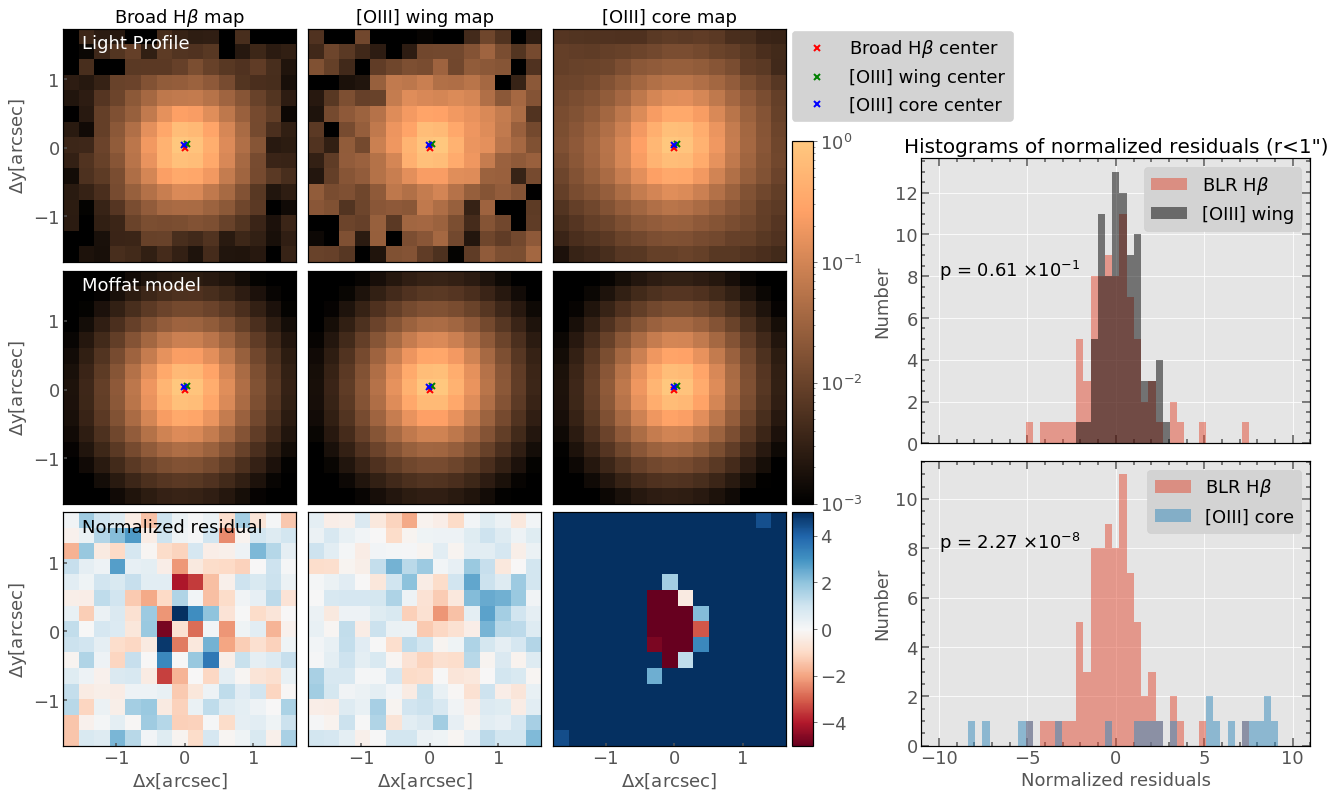

HE2222-0026
1.0171163990931604
[0.03328781127929688, 0.010660934448242189] [-0.0056861877441406255, 0.0060405731201171875]
10
0 0.01


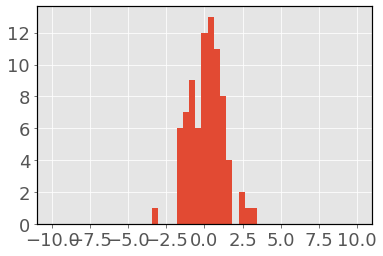

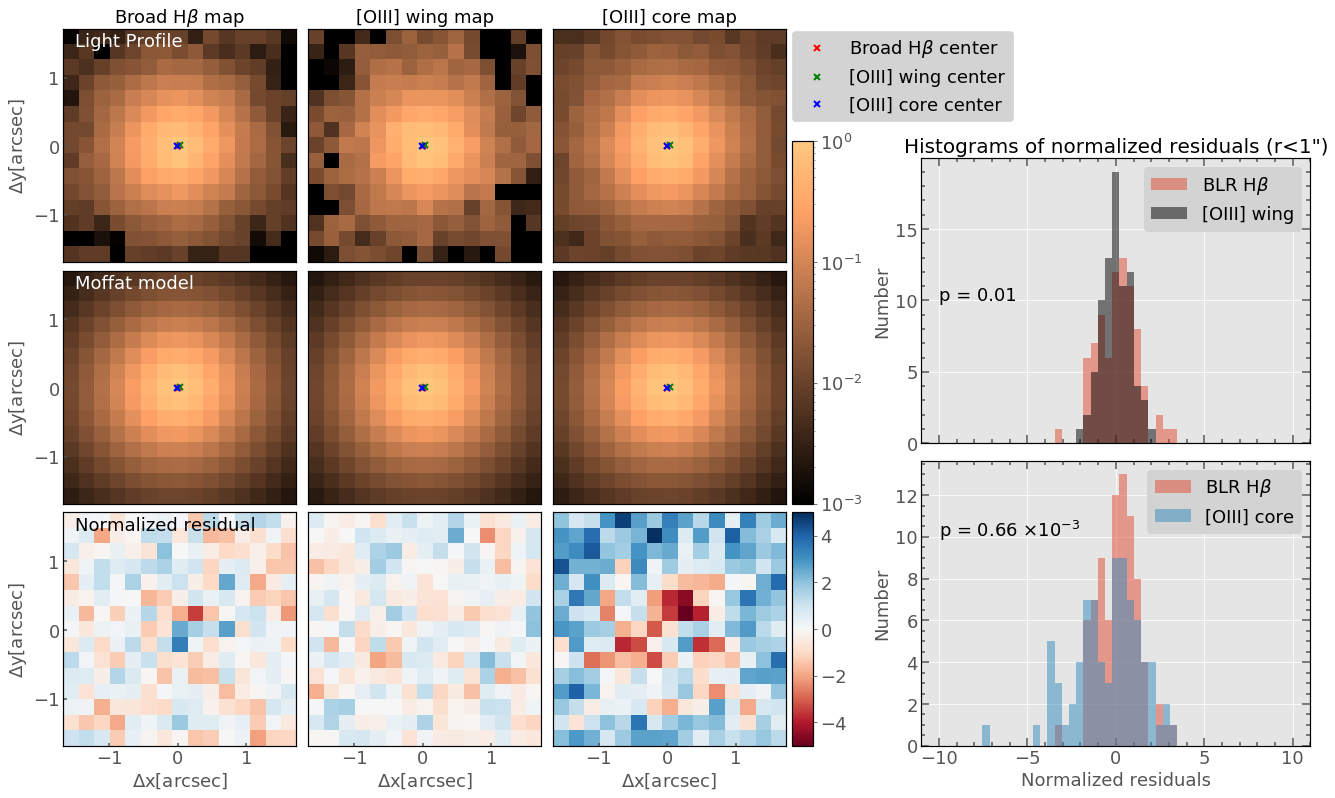

HE2233+0124
1.0358132347740632
[0.01052398681640625, 0.0052356719970703125] [-0.039842224121093756, 0.0012081146240234377]
4
0 0.18


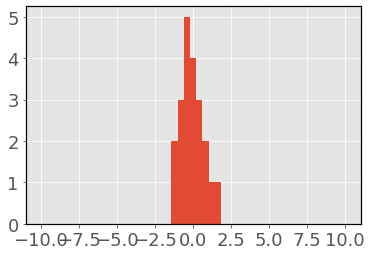

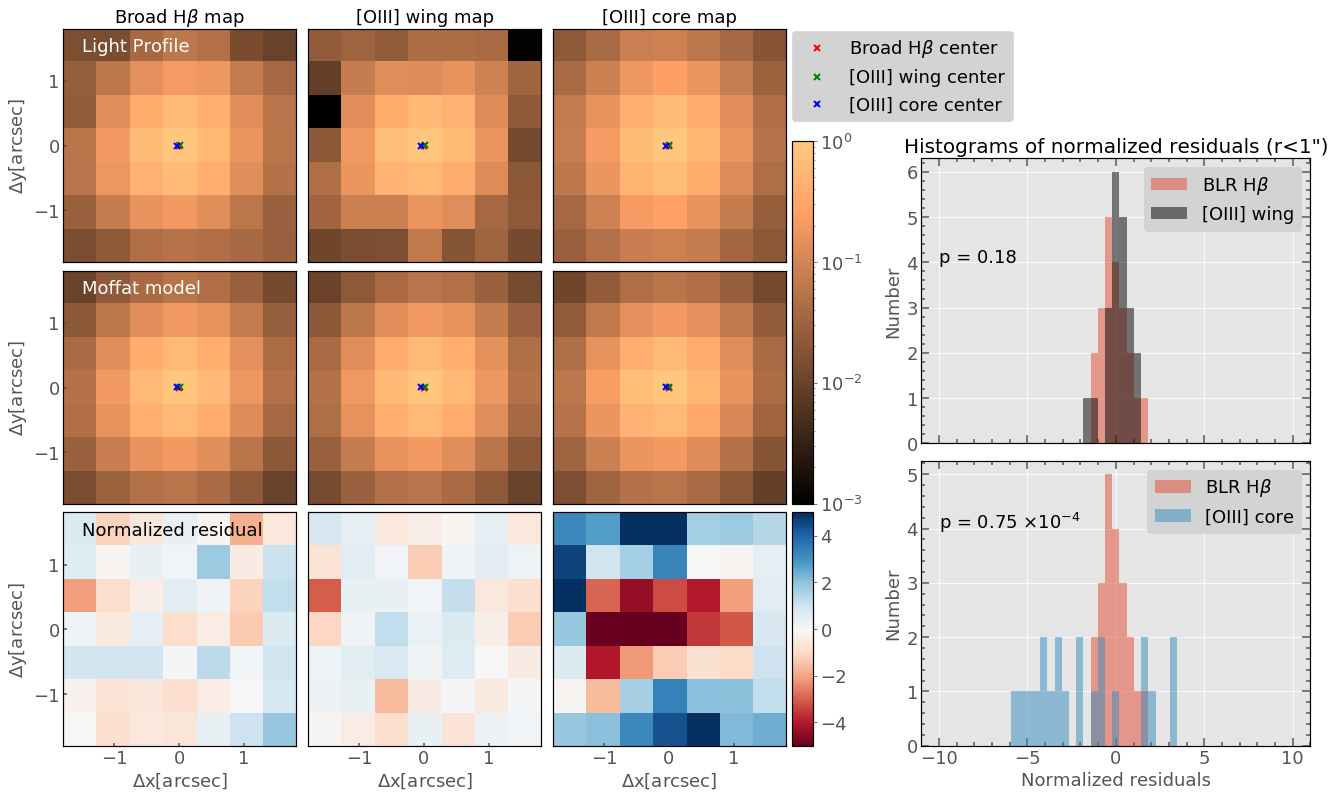

HE2302-0857
1.067400621996496
[0.10614242553710938, 0.019847488403320315] [-0.2006725311279297, -0.05818290710449219]
10
-3 0.67


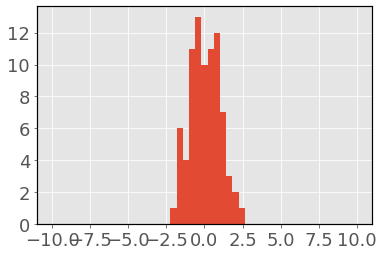

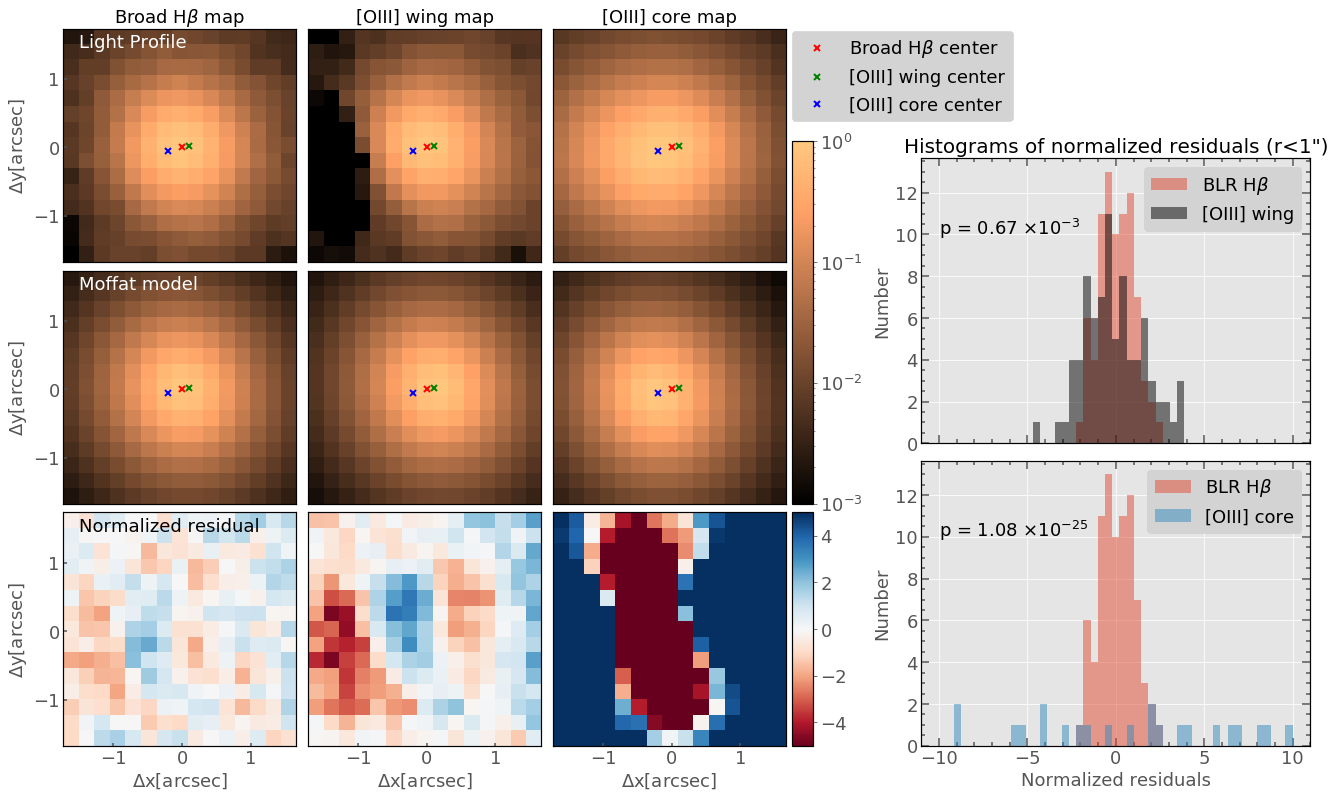

In [9]:
z = {"HE0021-1810":0.05352,"HE0021-1819":0.053197,"HE0040-1105":0.041692,"HE0108-4743":0.02392,"HE0114-0015":0.04560
    ,"HE0119-0118":0.054341,"HE0212-0059":0.026385,"HE0224-2834":0.059800,"HE0227-0913":0.016451,"HE0232-0900":0.043143
    ,"HE0253-1641":0.031588,"HE0345+0056":0.031,"HE0351+0240":0.036,"HE0412-0803":0.038160,"HE0429-0247":0.042009
    ,"HE0433-1028":0.035550,"HE0853+0102":0.052,"HE0934+0119":0.050338,"HE1011-0403":0.058314,"HE1017-0305":0.049986
    ,"HE1029-1831":0.040261,"HE1107-0813":0.058,"HE1108-2813":0.024013,"HE1126-0407":0.061960,"HE1237-0504":0.009
    ,"HE1248-1356":0.01465,"HE1330-1013":0.022145,"HE1353-1917":0.035021,"HE1417-0909":0.044,"HE2128-0221":0.05248
    ,"HE2211-3903":0.039714,"HE2222-0026":0.059114,"HE2233+0124":0.056482,"HE2302-0857":0.046860}

d_a = {"HE0021-1810":215.0,"HE0021-1819":213.8,"HE0040-1105":170.9,"HE0108-4743":100.1,"HE0114-0015":186.0
    ,"HE0119-0118":218.1,"HE0212-0059":109.5,"HE0224-2834":238.5,"HE0227-0913":69.07,"HE0232-0900":175.5
    ,"HE0253-1641":130.2,"HE0345+0056":127.9,"HE0351+0240":147.7,"HE0412-0803":156.1,"HE0429-0247":171.1
    ,"HE0433-1028":145.9,"HE0853+0102":209.3,"HE0934+0119":203.0,"HE1011-0403":233.0,"HE1017-0305":201.7
    ,"HE1029-1831":164.3,"HE1107-0813":231.8,"HE1108-2813":99.91,"HE1126-0407":246.5,"HE1237-0504":38.346
    ,"HE1248-1356":61.64,"HE1330-1013":92.344,"HE1353-1917":143.8,"HE1417-0909":178.8,"HE2128-0221":211.1
    ,"HE2211-3903":162.2,"HE2222-0026":236.0,"HE2233+0124":226.2,"HE2302-0857":189.8}

asymmetry = {"HE0021-1810":False,"HE0021-1819":True,"HE0040-1105":True,"HE0108-4743":False,"HE0114-0015":False
    ,"HE0119-0118":False,"HE0212-0059":False,"HE0224-2834":False,"HE0227-0913":False,"HE0232-0900":False
    ,"HE0253-1641":False,"HE0345+0056":False,"HE0351+0240":False,"HE0412-0803":False,"HE0429-0247":False
    ,"HE0433-1028":False,"HE0853+0102":False,"HE0934+0119":True,"HE1011-0403":False,"HE1017-0305":False
    ,"HE1029-1831":False,"HE1107-0813":False,"HE1108-2813":True,"HE1126-0407":False,"HE1237-0504":True
    ,"HE1248-1356":False,"HE1330-1013":True,"HE1353-1917":True,"HE1417-0909":False,"HE2128-0221":False
    ,"HE2211-3903":False,"HE2222-0026":False,"HE2233+0124":False,"HE2302-0857":False}

objs = z.keys()

for obj in objs:
    algorithm_script(obj,d_a[obj],asymmetry[obj])



In [10]:
def scientific_notation(p):
    if p < 0.01:
        k = 10**(np.log10(p) - np.round(np.log10(p)))
        q = np.round(k,2)
        l = int(np.log10(p/q))
    else:
        q = np.round(p,2)
        l = 0
    return (l,q)        

In [11]:
p = 0.88
(a,b) = scientific_notation(p)
print (a,b)

0 0.88
